# Preamble

In [51]:
HomeDir = '/Users/kvantilburg/Dropbox/projects/LuminousBasin/LuminousBasin/luminous-basin/'
DataDir = HomeDir+'data/poisson_data/'
EnergyDir = HomeDir+'data/energy_res_data/'
ProductionDir = HomeDir+'data/production/'
FigDir = HomeDir+'figs/'
import sys
sys.path.insert(0, HomeDir)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from preamble import *

from myUnits import *

from LuminousBasinFunctions import *

In [52]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})
#rc('text', usetex=True)

# Energy Resolution

## Load energy resolution data

In [3]:
list_files = listdir(EnergyDir); 
list_files = [file for file in list_files if file[0:2]=='nu'] #select only files starting with 'nu'
list_files

['nu20012004002B06_cl_sunpos.csv',
 'nu20001002001B06_cl_sunpos.csv',
 'nu20012003001A06_cl_sunpos.csv',
 'nu20012002001A06_cl_sunpos.csv',
 'nu20012001001A06_cl_sunpos.csv',
 'nu20012004002A06_cl_sunpos.csv',
 'nu20012002001B06_cl_sunpos.csv',
 'nu20012003001B06_cl_sunpos.csv',
 'nu20001002001A06_cl_sunpos.csv']

In [5]:
list_tables = []
list_X = []
list_Y = []
list_E = []
list_t = []
list_t_min = []
list_t_max = []

for file in list_files:
    table = pd.read_csv(EnergyDir+file)
    X = np.asarray(table[' Sun X (arcsec)'])
    Y = np.asarray(table[' Sun Y (arcsec)'])
    E = np.asarray(table[' Energy (keV)'])
    t = np.asarray(table['# Time (s)'])
    
    list_tables.append(table)
    list_X.append(X); list_Y.append(Y); list_E.append(E); list_t.append(t)
    list_t_min.append(list_t_min); list_t_max.append(list_t_max); 
    
all_X = np.asarray([item for X in list_X for item in X])
all_Y = np.asarray([item for Y in list_Y for item in Y])
all_E = np.asarray([item for E in list_E for item in E])
all_t = np.asarray([item for t in list_t for item in t])
    
[len(table) for table in list_tables]

[26208, 19396, 55211, 27867, 3881, 68130, 3099, 21417, 94976]

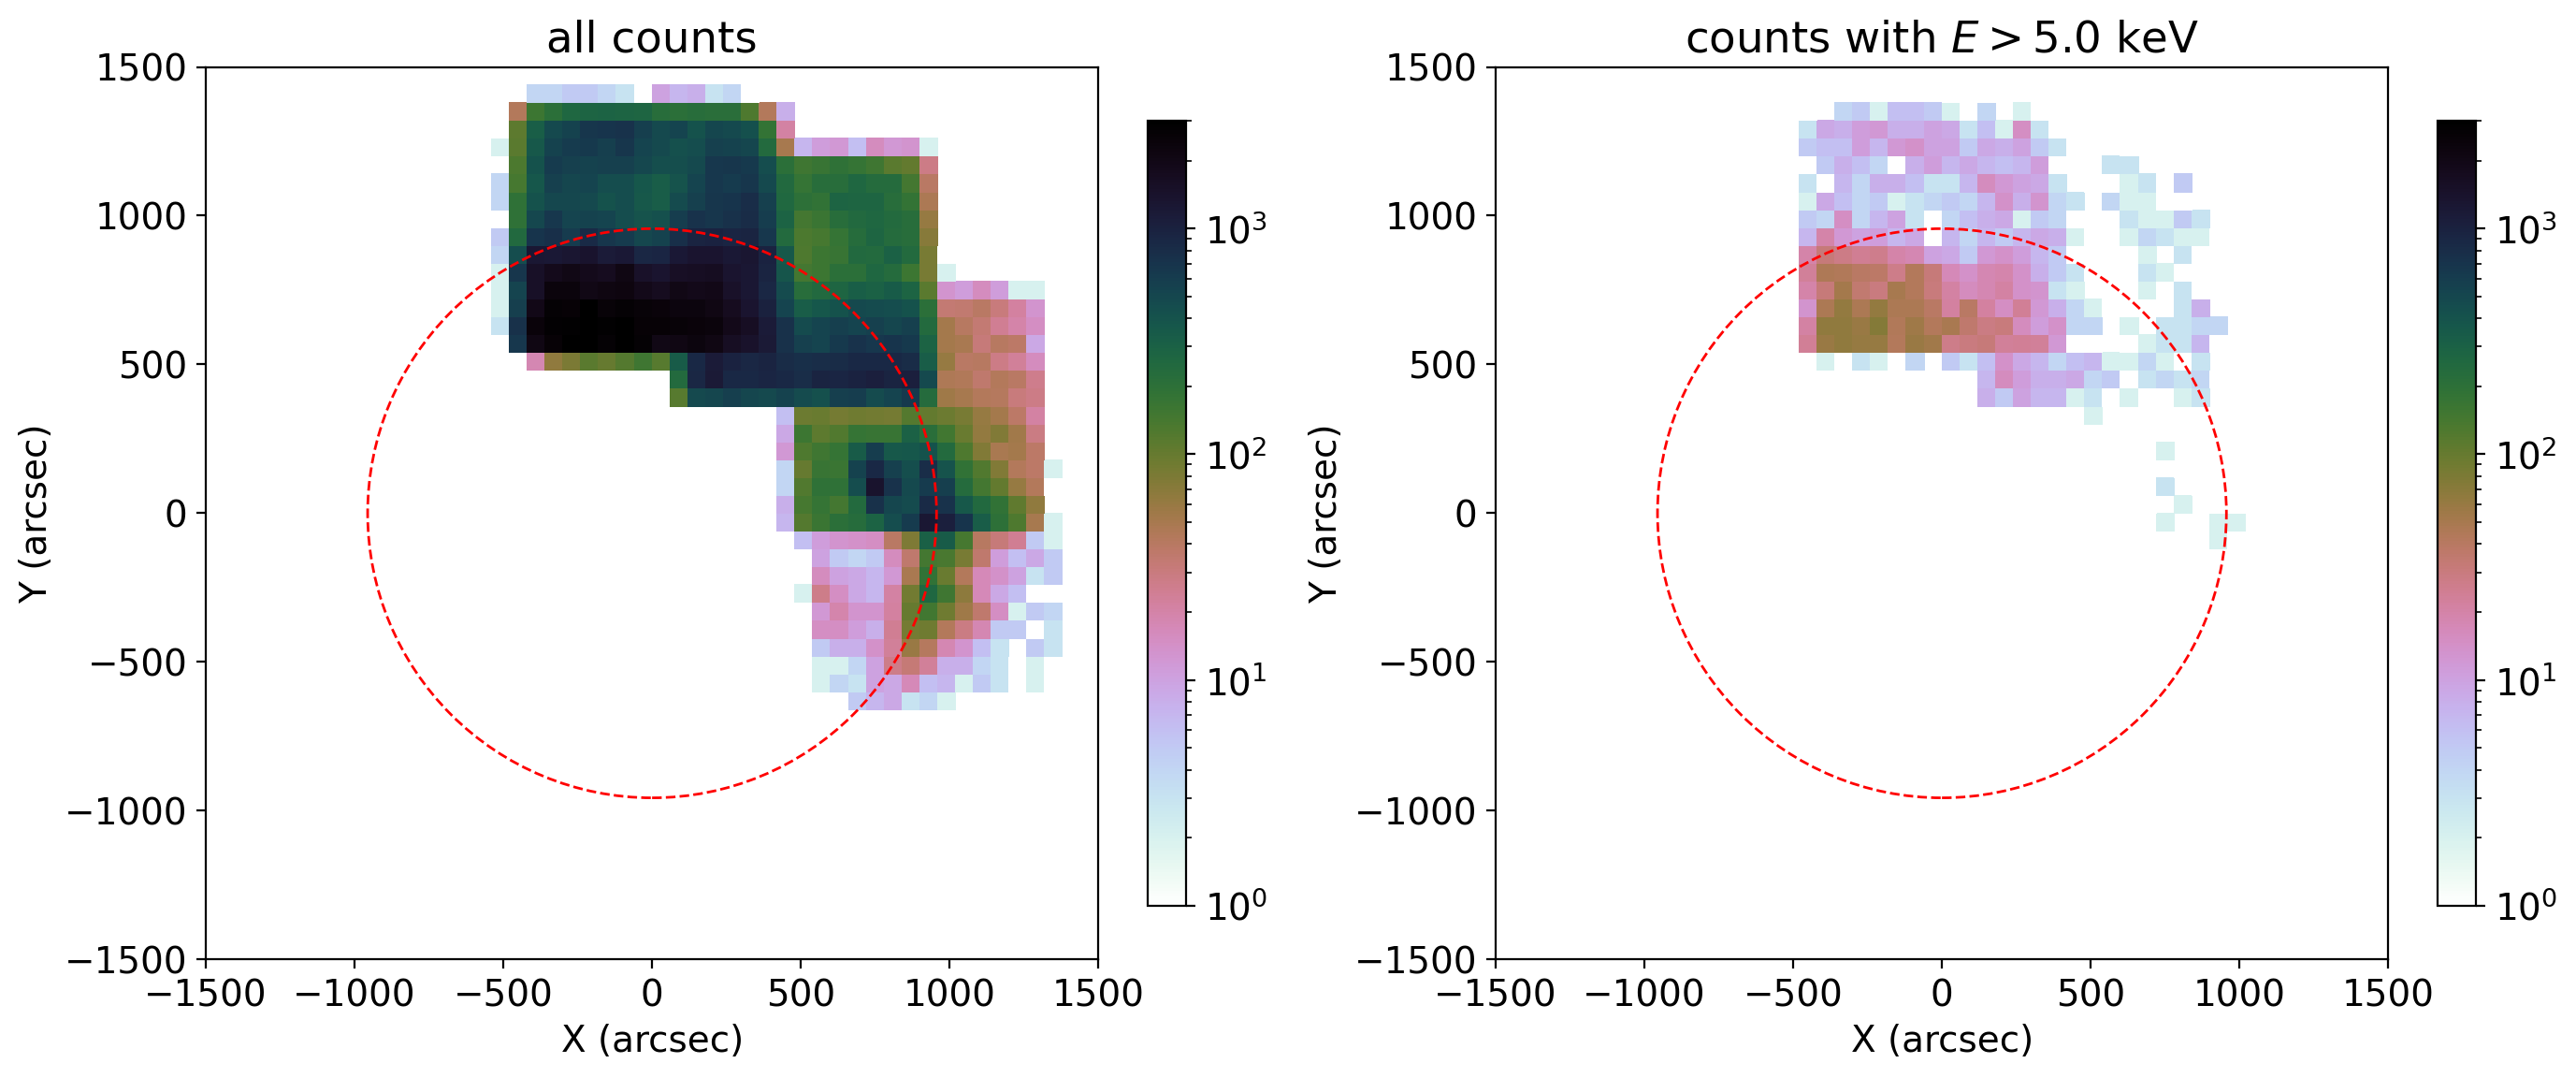

In [6]:
lim_XY = 1500
threshold = 5.0; #energy threshold of panel threshold
vmin = 1
vmax = 3e3
fig, ax = plt.subplots(1,2,figsize=(14,8))
h0 = ax[0].hist2d(all_X,all_Y,bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h0[3],ax=ax[0],fraction=0.04)
ax[0].set_xlabel('X (arcsec)'); ax[0].set_ylabel('Y (arcsec)');
ax[0].set_title('all counts')
h1 = ax[1].hist2d(all_X[all_E>threshold],all_Y[all_E>threshold],bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h1[3],ax=ax[1],fraction=0.04)
ax[1].set_xlabel('X (arcsec)'); ax[1].set_ylabel('Y (arcsec)');
ax[1].set_title('counts with $E > $'+str(threshold)+' keV')
ax[0].set_aspect(1); ax[1].set_aspect(1);
circle1 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False); circle2 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False)
ax[0].add_artist(circle1); ax[1].add_artist(circle2);
fig.tight_layout()

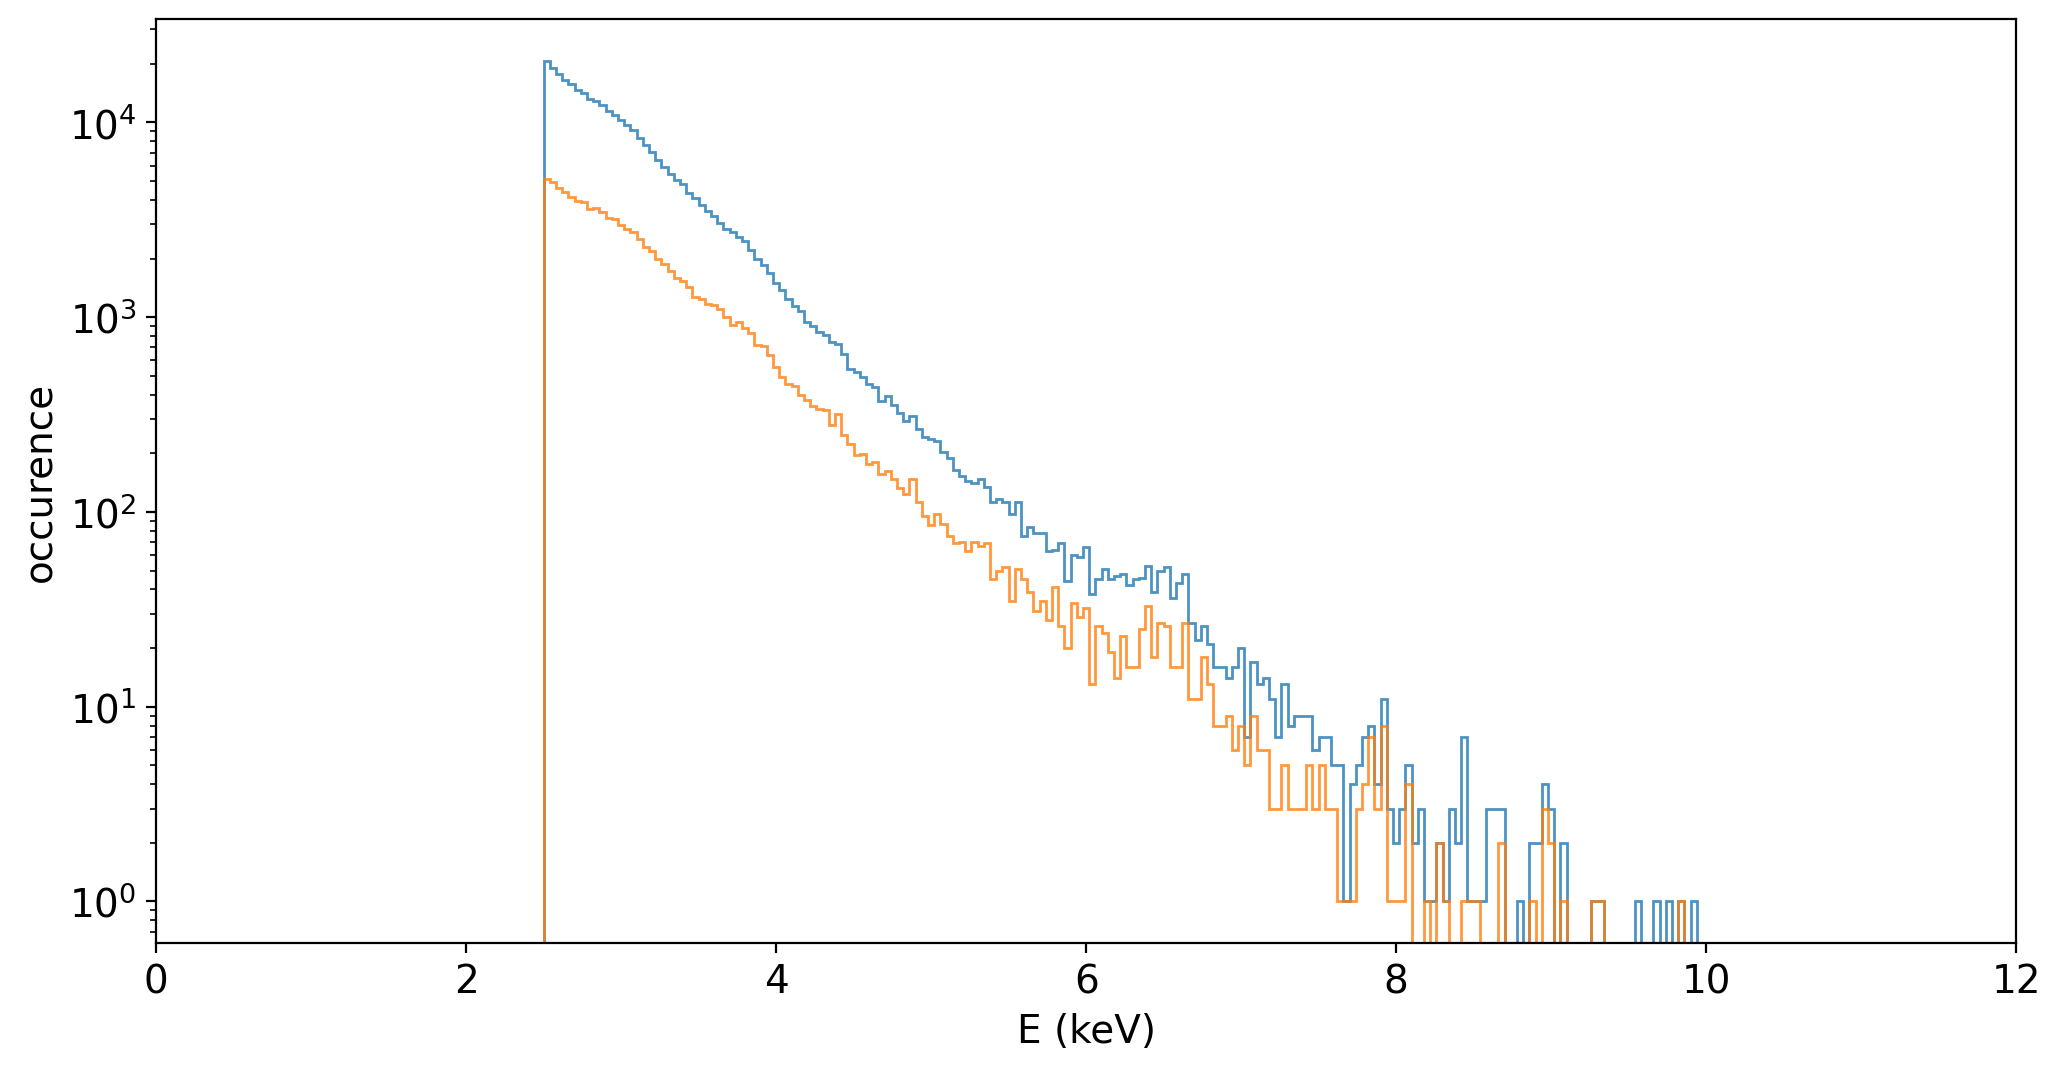

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
i_tab = 8
[hist_E,E_edges,image] = ax.hist(all_E,bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.hist(list_E[i_tab],bins=np.arange(0.02,12.0,0.04),log=True,histtype='step',alpha=0.8);
ax.set_xlim(0,12); ax.set_xlabel('E (keV)'); ax.set_ylabel('occurence');

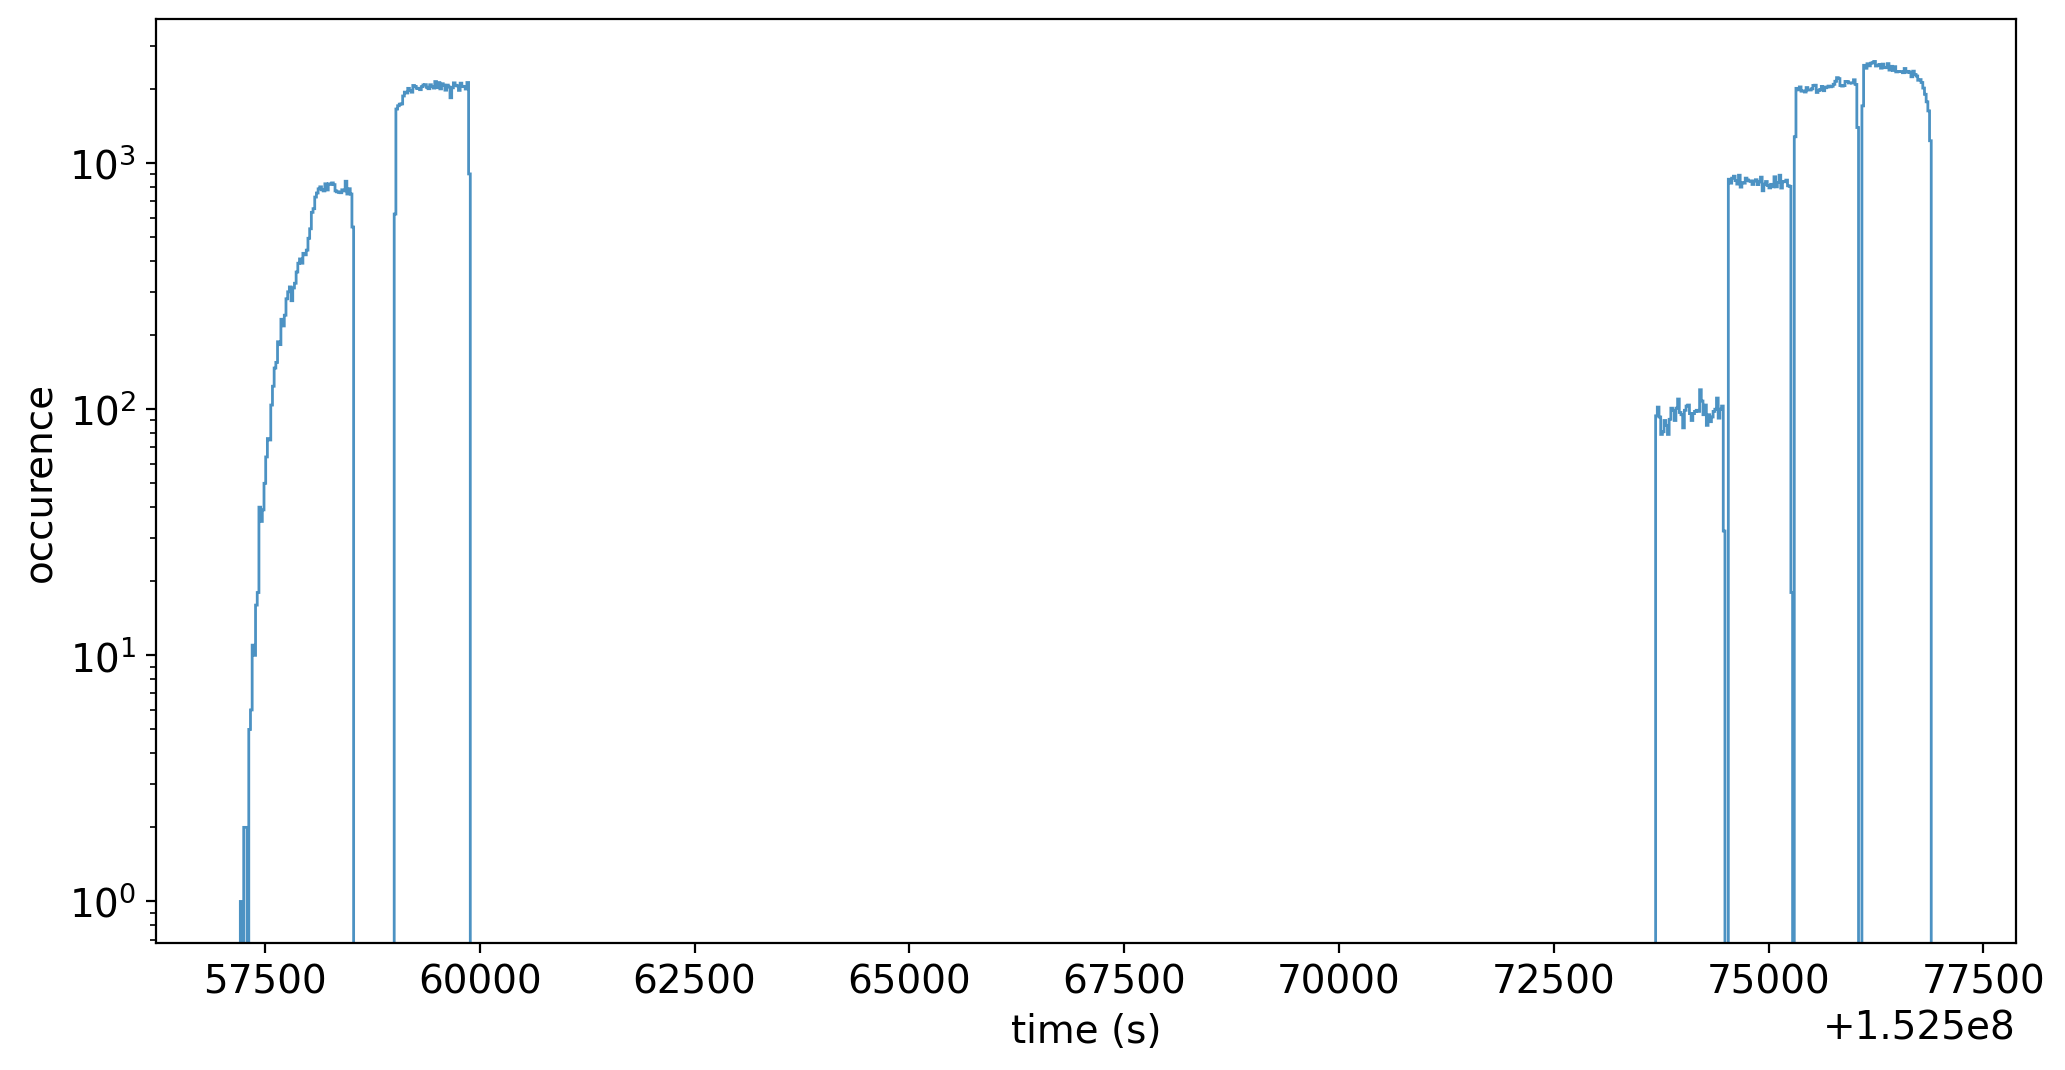

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(all_t,bins=1000,log=True,histtype='step',alpha=0.8);
#ax.set_xlim(0,12); 
ax.set_xlabel('time (s)'); ax.set_ylabel('occurence');

## Energy resolution

In [9]:
def fit_fun(E, count_cont, E_min, E_line, sigma_E, count_line):
    """fitting function of Boltzmann-suppressed continuum emission plus a Gaussian line"""
    return count_cont * np.exp(-(E/E_min-1)) + count_line * np.exp(- (E-E_line)**2/(2*sigma_E**2))

E_fit_min = 5.6; E_fit_max = 7.2;
indices_fit = [E_fit_min<E<E_fit_max for E in E_edges] # fit from 4 keV to 7 keV
p0 = [5e4, 0.7, 6.4, 0.4, 0]
[p_fit,p_cov] = curve_fit(fit_fun,xdata=E_edges[indices_fit],ydata=hist_E[indices_fit[:-1]],p0=p0,sigma=np.sqrt(hist_E[indices_fit[:-1]]))

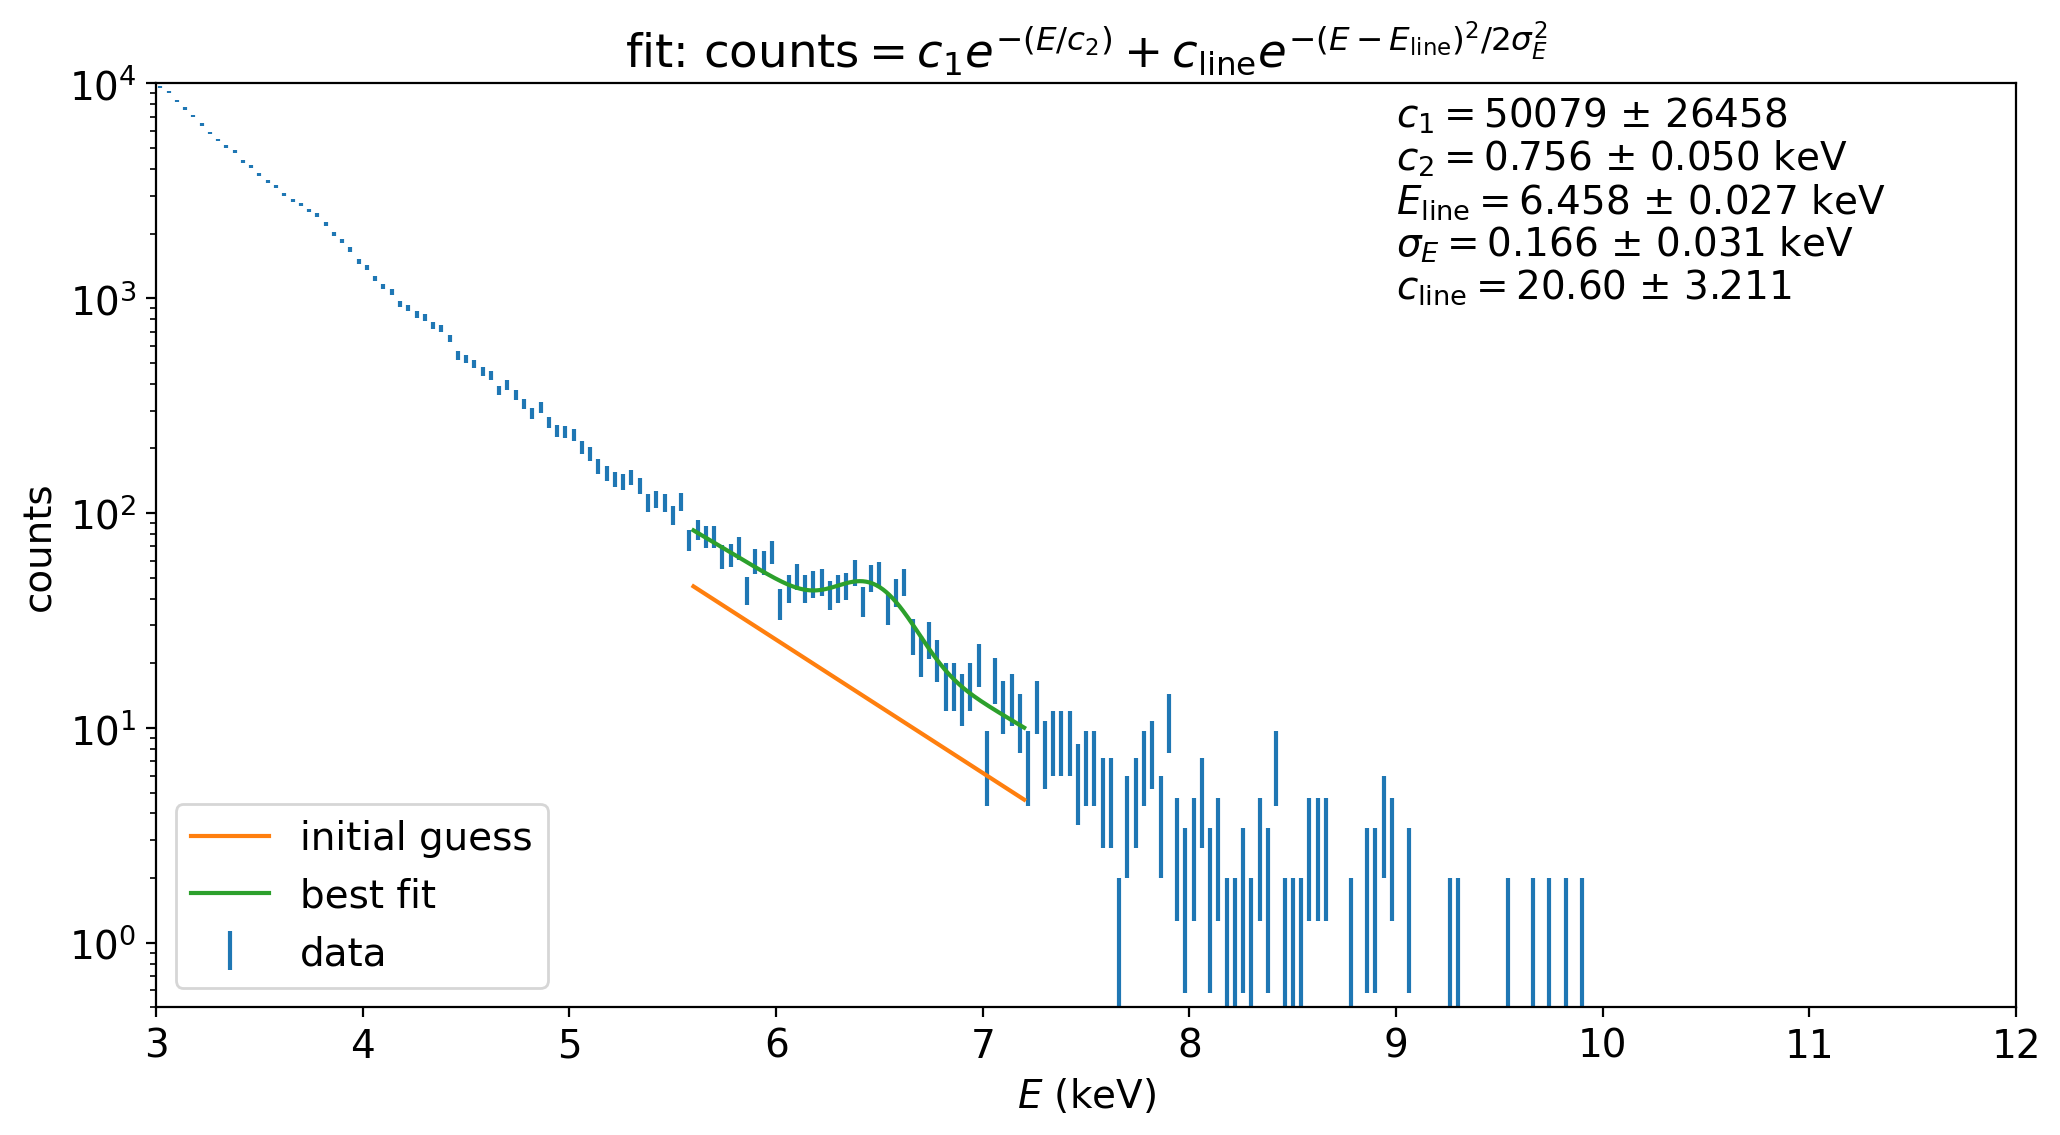

In [11]:
vec_E = np.linspace(E_fit_min,E_fit_max,200)
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.errorbar(E_edges[:-1],hist_E,np.sqrt(hist_E),fmt='none', label='data')
ax.plot(vec_E,fit_fun(vec_E, p0[0],p0[1],p0[2],p0[3],p0[4]), label='initial guess')
ax.plot(vec_E,fit_fun(vec_E, p_fit[0],p_fit[1],p_fit[2],p_fit[3],p_fit[4]), label='best fit')
ax.set_yscale('log'); ax.set_ylim(0.5,1e4); ax.set_xlim(3,12);
ax.set_title(r'fit: $\mathrm{counts} = c_1 e^{-(E/c_2)} + c_\mathrm{line} e^{-(E-E_\mathrm{line})^2/2\sigma_E^2}$');
ax.text(9,10**3.8,'$c_1 = $'+str(p_fit[0])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[0,0]))[0:5]);
ax.text(9,10**3.6,'$c_2 = $'+str(p_fit[1])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[1,1]))[0:5]+' keV');
ax.text(9,10**3.4,'$E_\mathrm{line} = $'+str(p_fit[2])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[2,2]))[0:5]+' keV');
ax.text(9,10**3.2,'$\sigma_E = $'+str(p_fit[3])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[3,3]))[0:5]+' keV');
ax.text(9,10**3.0,'$c_\mathrm{line} = $'+str(p_fit[4])[0:5]+' $\pm$ '+str(np.sqrt(p_cov[4,4]))[0:5]);
ax.set_xlabel('$E$ (keV)'); ax.set_ylabel('counts')
ax.legend(loc='lower left');

In [17]:
fig.savefig(FigDir+'energy_res.pdf',bbox_inches='tight',pad_inches=0.02);

# Load Signal Data

## Load photons

In [18]:
list_files = listdir(DataDir+'ORBIT_1/'); 
list_files = [file for file in list_files if file[0:2]=='nu'] #select only files starting with 'nu'
list_files

['nu80610202001B06_cl_sunpos_unfiltered.csv',
 'nu80610202001A06_arf.csv',
 'nu80610202001B06_arf.csv',
 'nu80610202001A06_cl_sunpos_unfiltered.csv']

In [19]:
list_data = [file for file in list_files if file[-14:]=='unfiltered.csv']
list_data

['nu80610202001B06_cl_sunpos_unfiltered.csv',
 'nu80610202001A06_cl_sunpos_unfiltered.csv']

In [20]:
X = []; Y = []; E = []; t = [];
for file in list_data:
    print(file)
    table = pd.read_csv(DataDir+'ORBIT_1/'+file)
    X = np.append(X, table[' SunX (arcsec)'])
    Y = np.append(Y, table[' SunY (arcsec)'])
    E = np.append(E, table[' Energy (keV)'])
    t = np.append(t, table['# Time (s)'])

nu80610202001B06_cl_sunpos_unfiltered.csv
nu80610202001A06_cl_sunpos_unfiltered.csv


## Define source region

From sourceregion.txt:

In [21]:
rect_XY_vertices = np.asarray([
    [-938.8914745, 565.02517878],
    [-439.05125918, -131.36566626],
    [-1616.62316137, 78.57772551],
    [-1116.78294606, -617.81311953]])

In [22]:
rect_XY_center = np.mean(rect_XY_vertices,axis=0)
rect_XY_center

array([-1027.83721028,   -26.39397037])

In [23]:
rect_XY_angle = np.arctan((rect_XY_vertices[1,1]-rect_XY_vertices[3,1])/(rect_XY_vertices[1,0]-rect_XY_vertices[3,0]))
rect_XY_angle / degree

35.669203266179565

choose rectangle to be 90% linear containment

In [24]:
rect_XY_size = 0.9 * np.linalg.norm(rect_XY_vertices[0]-rect_XY_vertices[1])
rect_XY_size

771.4845198864344

In [25]:
rect_XY_anchor = rect_XY_center + rect_XY_size * np.asarray([[np.cos(rect_XY_angle),-np.sin(rect_XY_angle)],
                                                             [np.sin(rect_XY_angle),np.cos(rect_XY_angle)]]) @ np.asarray([-0.5,-0.5])

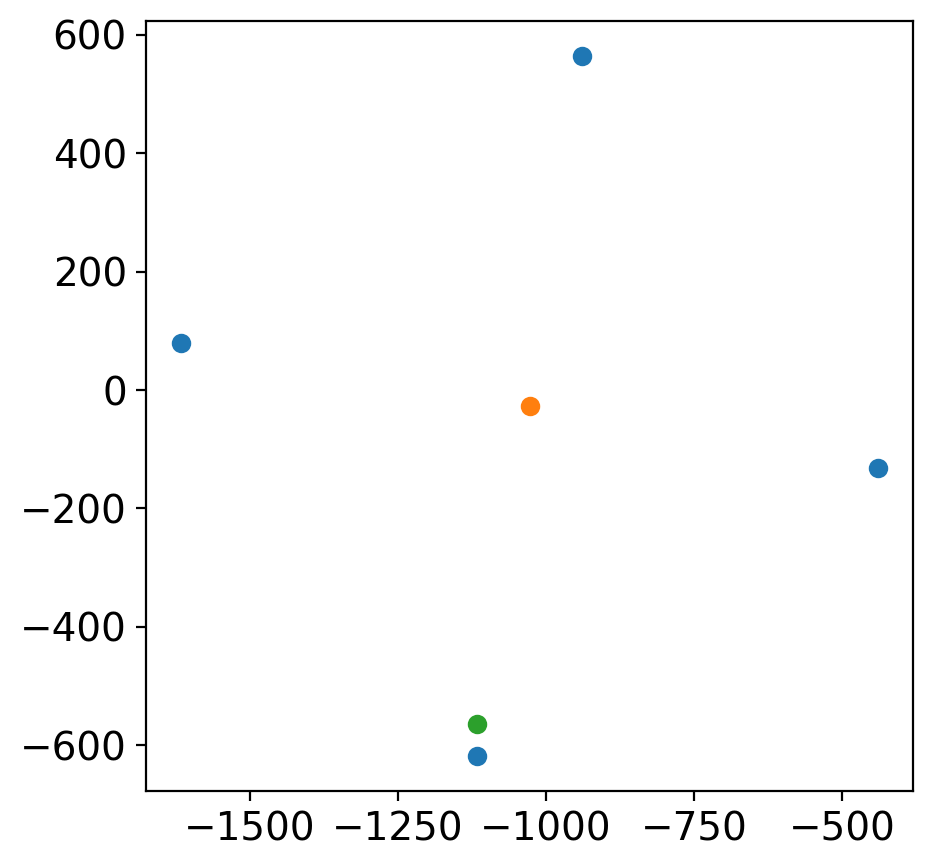

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(rect_XY_vertices[:,0],rect_XY_vertices[:,1])
ax.scatter(rect_XY_center[0],rect_XY_center[1])
ax.scatter(rect_XY_anchor[0],rect_XY_anchor[1])
ax.set_aspect('equal')

In [27]:
t_min = np.min(t)
t_max = np.max(t)
(t_min, t_max)

(337603341.0614887, 337606914.8196474)

## Plots

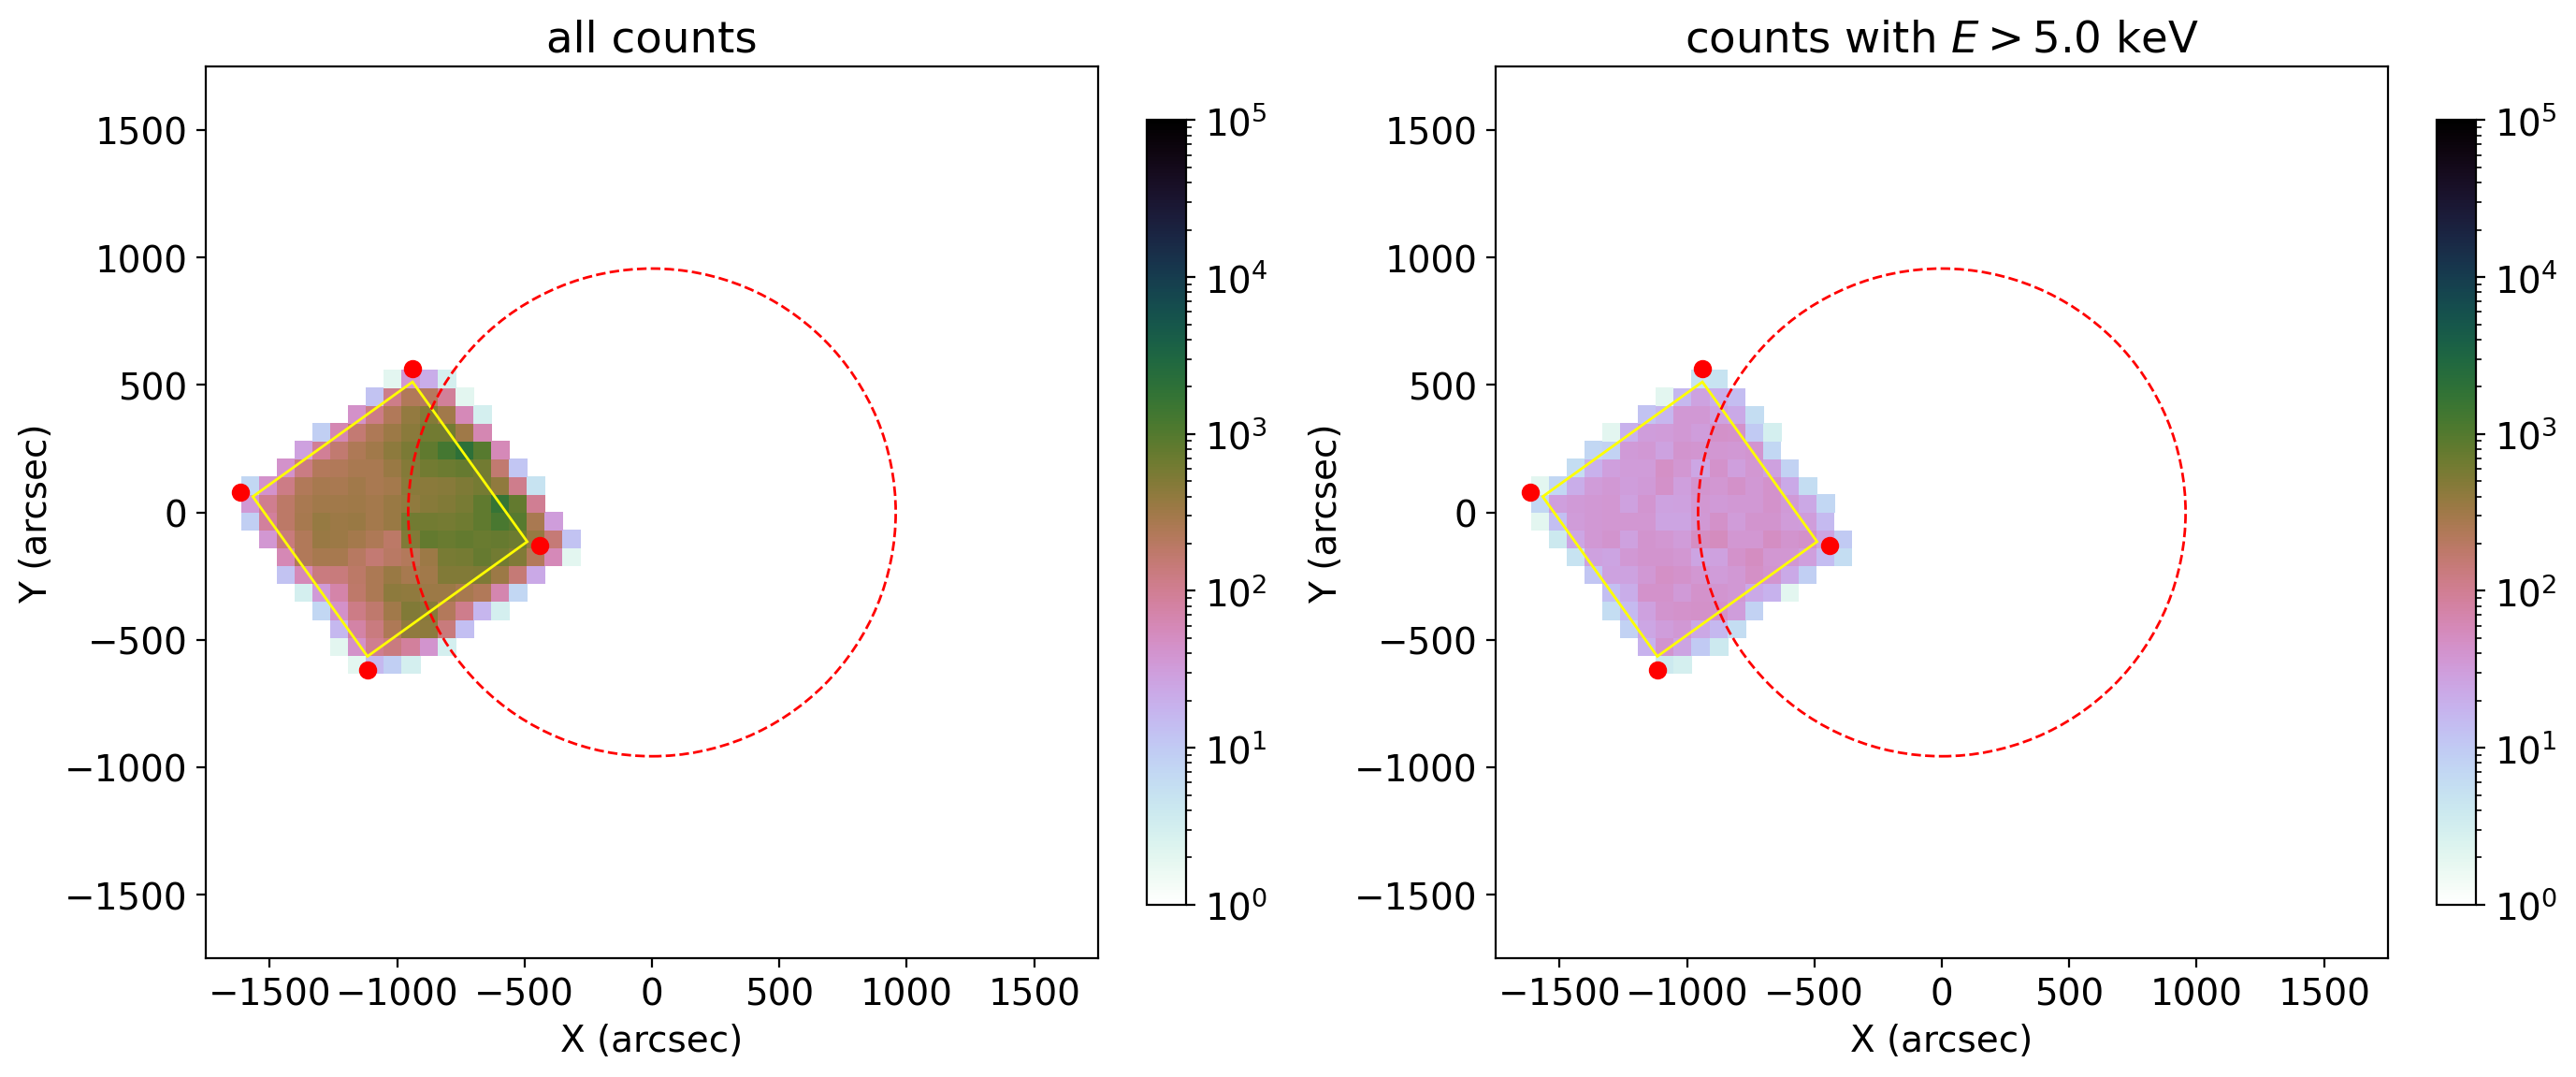

In [28]:
lim_XY = 1750
threshold = 5.0; #energy threshold of panel threshold
vmin = 1
vmax = 1e5
fig, ax = plt.subplots(1,2,figsize=(14,8))
h0 = ax[0].hist2d(X,Y,bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h0[3],ax=ax[0],fraction=0.04)
ax[0].set_xlabel('X (arcsec)'); ax[0].set_ylabel('Y (arcsec)');
ax[0].set_title('all counts')
ax[0].scatter(rect_XY_vertices[:,0],rect_XY_vertices[:,1],color='red')
rect0 = mpl.patches.Rectangle(rect_XY_anchor, rect_XY_size, rect_XY_size, angle=rect_XY_angle/degree,fill=False,color='yellow')
ax[0].add_patch(rect0)
h1 = ax[1].hist2d(X[E>threshold],Y[E>threshold],bins=[50,50],range=[[-lim_XY,lim_XY],[-lim_XY,lim_XY]],cmap='cubehelix_r',norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax));
fig.colorbar(h1[3],ax=ax[1],fraction=0.04)
ax[1].set_xlabel('X (arcsec)'); ax[1].set_ylabel('Y (arcsec)');
ax[1].set_title('counts with $E > $'+str(threshold)+' keV')
ax[1].scatter(rect_XY_vertices[:,0],rect_XY_vertices[:,1],color='red')
rect1 = mpl.patches.Rectangle(rect_XY_anchor, rect_XY_size, rect_XY_size, angle=rect_XY_angle/degree,fill=False,color='yellow')
ax[1].add_patch(rect1)
ax[0].set_aspect(1); ax[1].set_aspect(1);
circle1 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False); circle2 = plt.Circle((0, 0), theta_sun/arcsec, color='red', ls='dashed', fill=False)
ax[0].add_artist(circle1); ax[1].add_artist(circle2);
fig.tight_layout()

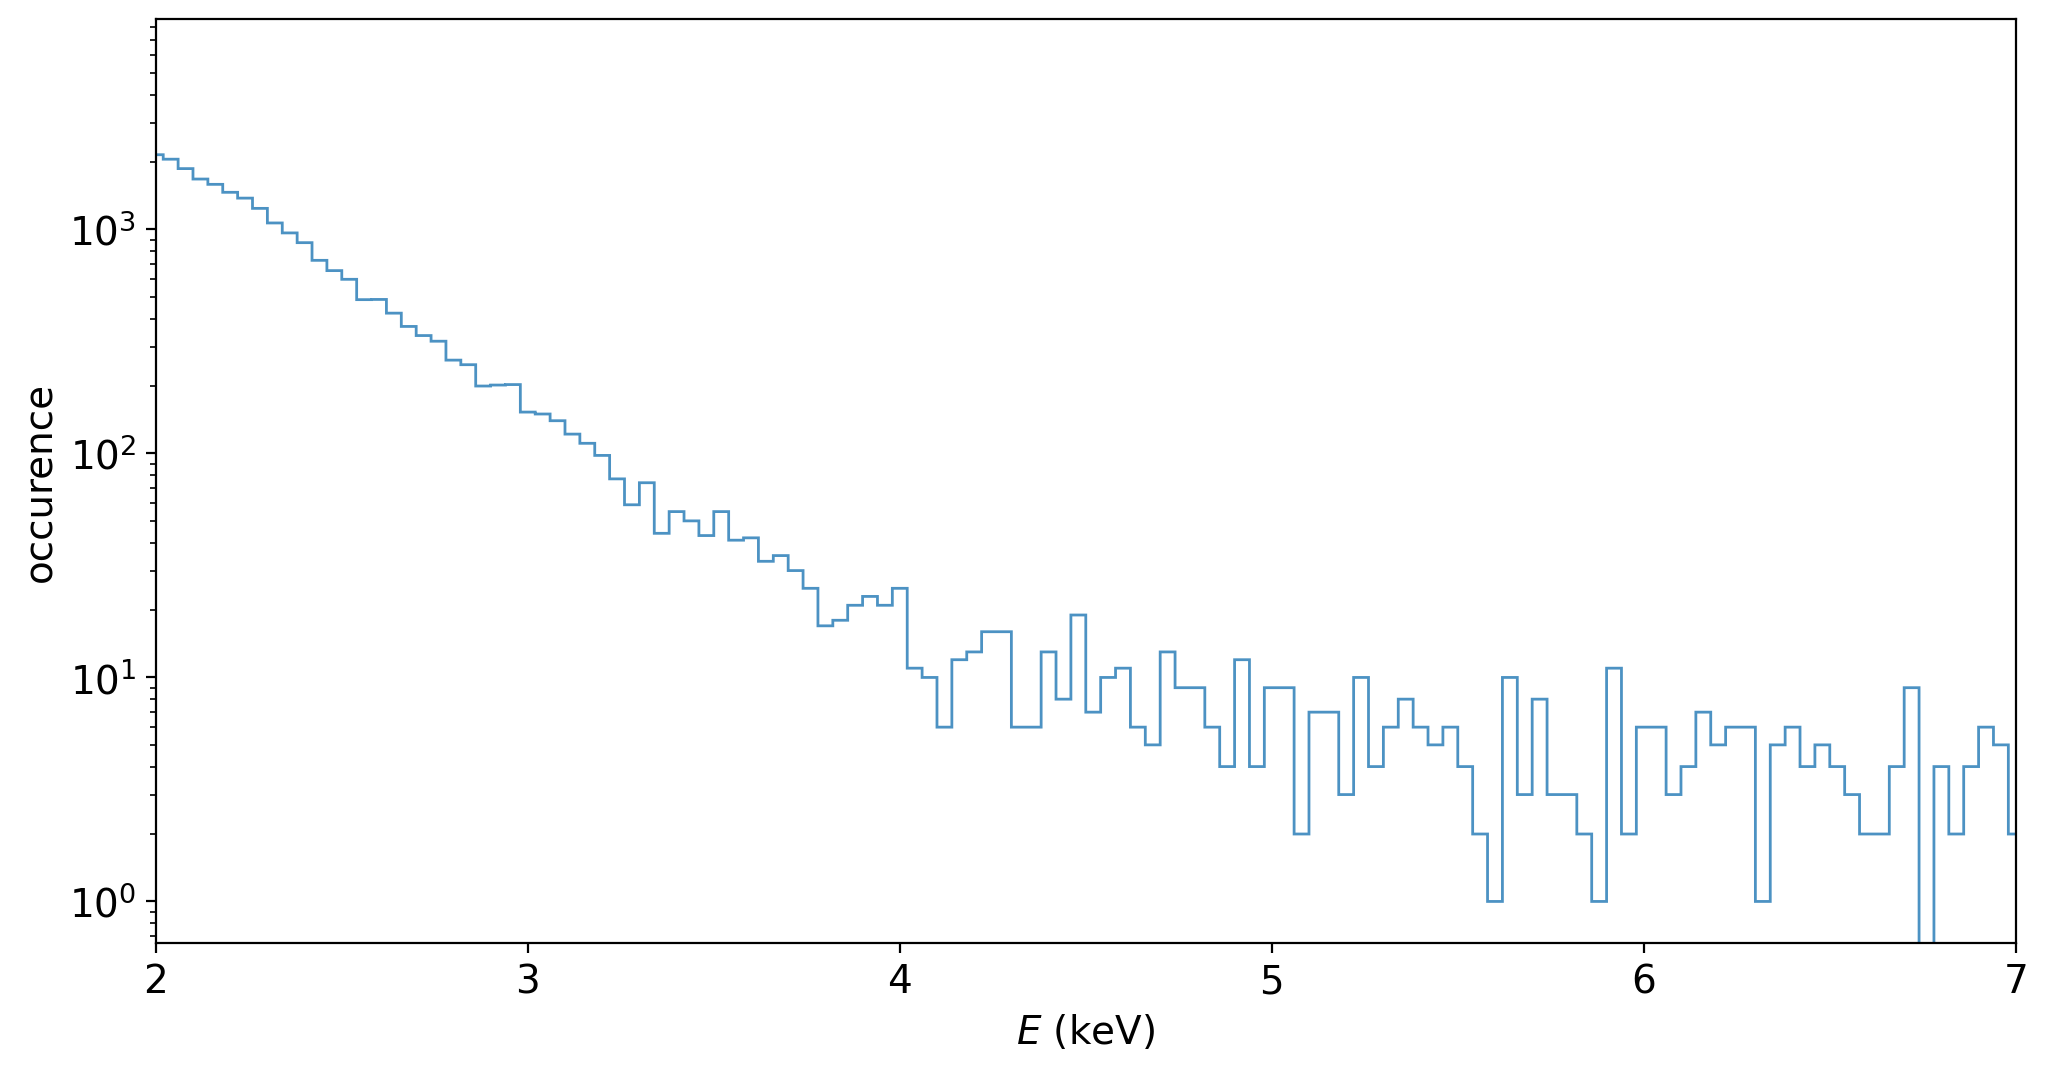

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
[hist_E,E_edges,image] = ax.hist(E,bins=np.arange(0.02,30.0,0.04),log=True,histtype='step',alpha=0.8);
ax.set_xlim(2,7); ax.set_xlabel('$E$ (keV)'); ax.set_ylabel('occurence');

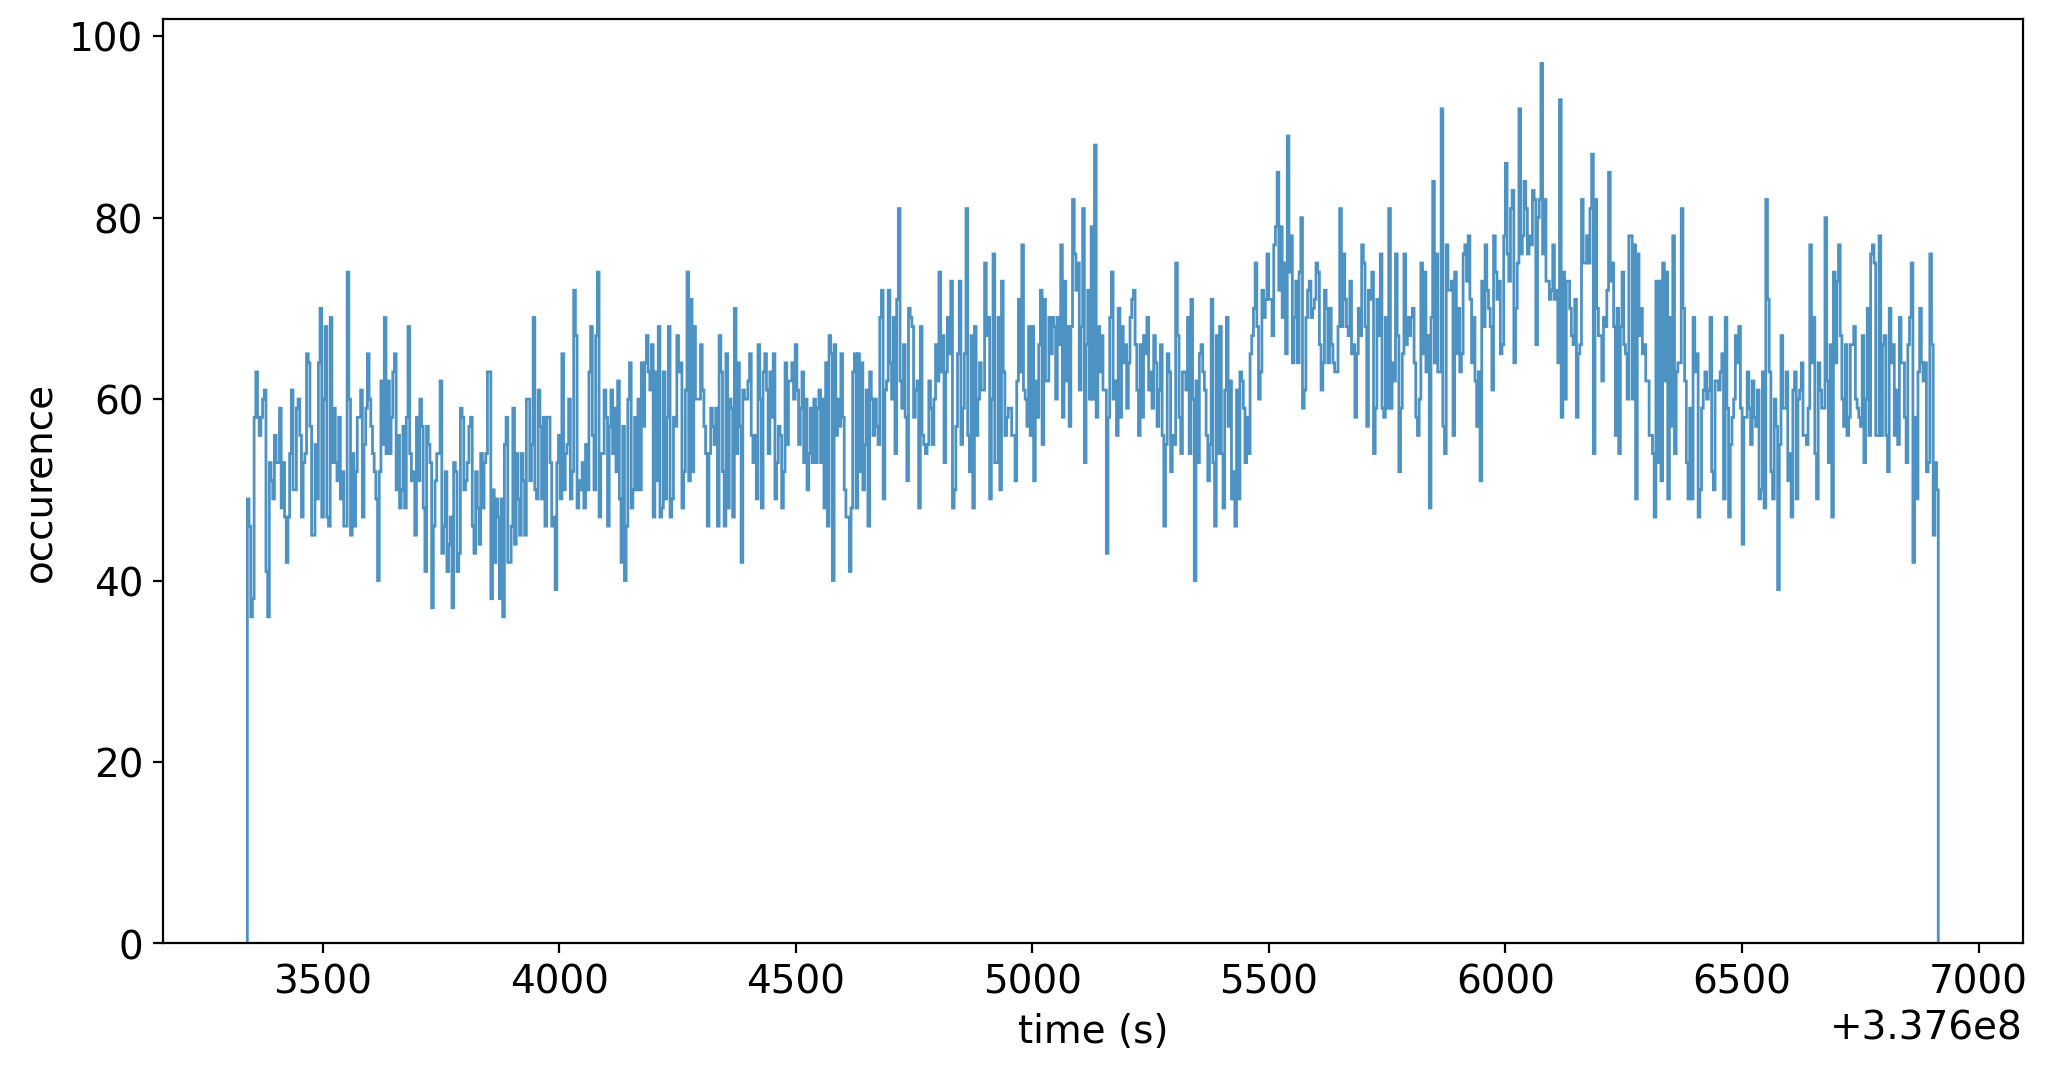

In [30]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
[hist_t,t_edges,image] = ax.hist(t,bins=1000,log=False,histtype='step',alpha=0.8);
ax.set_ylim(0,); #ax.set_xlim(0,12); 
ax.set_xlabel('time (s)'); ax.set_ylabel('occurence');

# Signal Calculation

## Intrinsic signal density

### Angular dependence

$\theta_\mathrm{sun}$ is the angular radius of the Sun at 1 AU

In [31]:
theta_sun = np.arcsin(RSolar/AU); print('theta_sun =',theta_sun/arcsec,'arcsec')

theta_sun = 956.3983296221267 arcsec


$z_\mathrm{min} = \sqrt{\sin^2 \theta_\mathrm{sun}  - \sin^2 \theta }$

In [32]:
def z_min(theta):
    """z_min function (returns zero if theta > theta_sun)"""
    theta = np.asarray(theta)
    vec_theta_sun = np.ones(theta.shape) * theta_sun
    vec_arg = np.minimum(theta,vec_theta_sun)
    return np.sqrt(np.sin(theta_sun)**2 - np.sin(vec_arg)**2)

flux template function: $$T(\theta) = \begin{cases} \frac{3\pi}{2} \sin^3 \theta_\mathrm{sun} \csc^3 \theta & \sin \theta  > \sin \theta_\mathrm{sun} \\ 
\frac{3}{4} \sin^3 \theta_\mathrm{sun} \csc^2\theta \left\lbrace \frac{4 z_\mathrm{min}}{-1 - 2 z_\mathrm{min}^2 + \cos 2 \theta } + [\pi - 2 \arctan(z_\mathrm{min} \csc \theta) \csc(\theta) ]\right\rbrace & \sin \theta \le \sin \theta_\mathrm{sun} \end{cases} $$

In [33]:
def T_flux_template(theta):
    theta = np.asarray(theta+1e-20); #(shift up to avoid dividing by zero)
    y = np.zeros(theta.shape)
    y += (theta > theta_sun) * 3 * np.pi / 2 * np.sin(theta_sun)**3 * np.sin(theta)**-3
    #curly_bracket = (4 * z_min(theta) / (-1 - 2*z_min(theta)**2+np.cos(2*theta)) + (np.pi - 2 * np.arctan(z_min(theta) * np.sin(theta)**-1) * np.sin(theta)**-1))
    y += (theta <= theta_sun) * 3 / 4 * np.sin(theta_sun)**3 * np.sin(theta)**-2 * (4 * z_min(theta) / (-1 - 2*z_min(theta)**2 + np.cos(2*theta)) + (np.pi - 2 * np.arctan(z_min(theta) * np.sin(theta)**-1)) * np.sin(theta)**-1)
    #y += (theta < theta_sun) * 3 / 4 * np.sin(theta_sun)**3 * np.sin(theta)**-2 * 
    return y

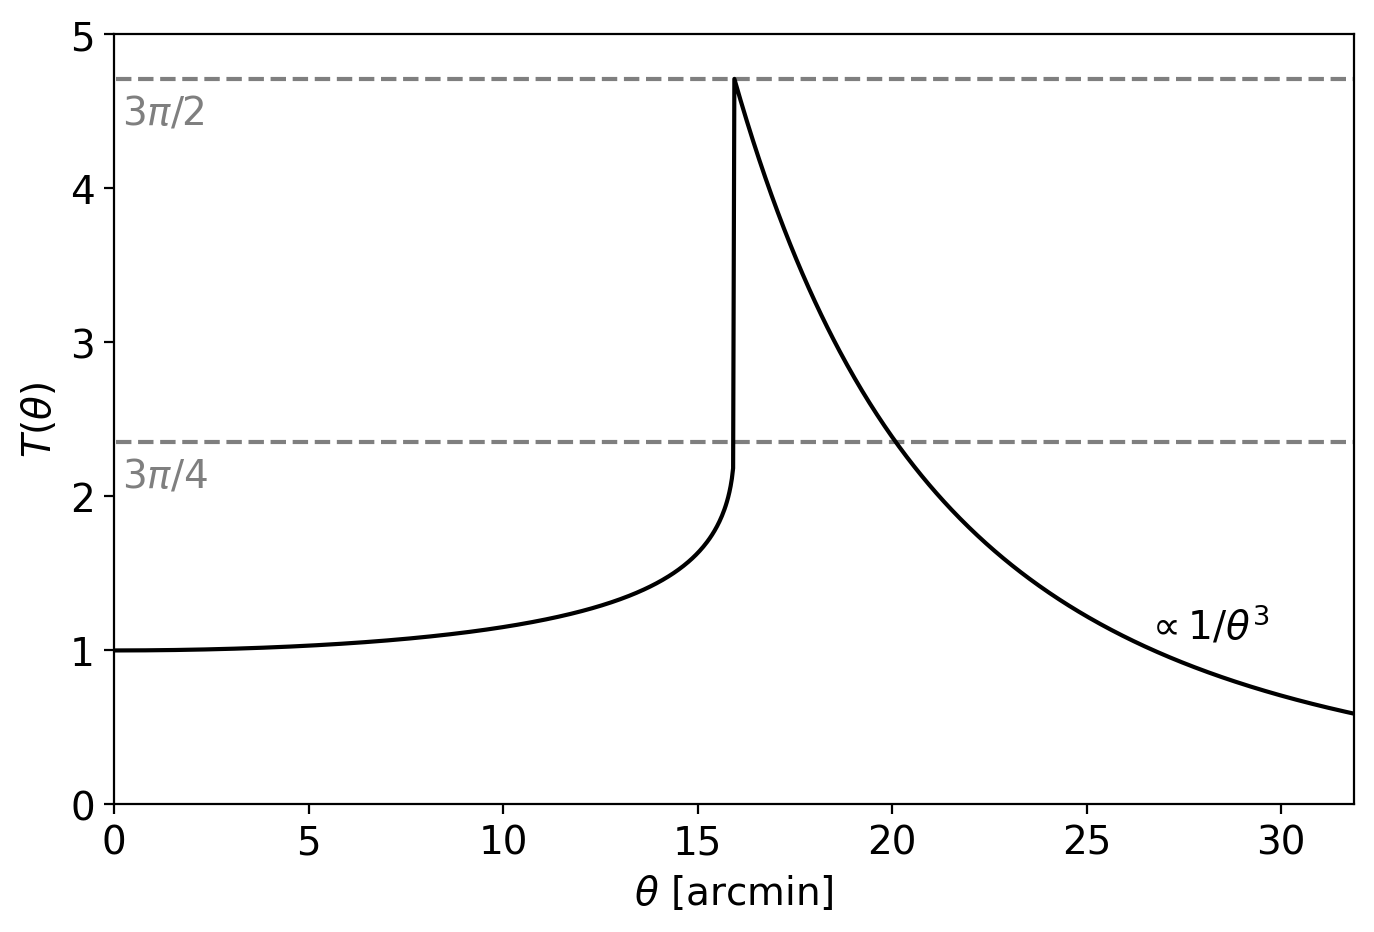

In [34]:
fig_template,ax = plt.subplots(1,1,figsize=(8,5))
vec_theta = np.linspace(1e-5,2*theta_sun,np.int(1e3))
ax.plot(vec_theta/arcmin, T_flux_template(vec_theta),color='black')
ax.set_ylim(0,5); ax.set_xlim(0,2*theta_sun/arcmin);
ax.set_xlabel(r'$\theta$ [arcmin]'); ax.set_ylabel(r'$T(\theta)$');
#ax.hlines(T_flux_template(theta_sun-1e-10),xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
#ax.hlines(T_flux_template(theta_sun+1e-10),xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.hlines(3*np.pi/2,xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.hlines(3*np.pi/4,xmin=vec_theta[0]/arcmin,xmax=vec_theta[-1]/arcmin,color=(0,0,0,0.5),ls='dashed');
ax.text(0.2,3*np.pi/2-0.1,r'$3 \pi / 2$',color=(0,0,0,0.5),ha='left',va='top');
ax.text(0.2,3*np.pi/4-0.1,r'$3 \pi / 4$',color=(0,0,0,0.5),ha='left',va='top');
ax.text(26.5,T_flux_template(26.5*arcmin),r'$\propto 1/\theta^3$',color=(0,0,0,1),ha='left',va='bottom');

In [36]:
fig_template.savefig(FigDir+'template.pdf',bbox_inches='tight',pad_inches=0.02);

### Axion decay rate

In [37]:
def Gamma_rad(m,gagg,gaee):
    """Decay rate in units of second^-1. Units: Gamma_rad, m [keV], gagg [GeV^-1]."""
    return (gagg)**2 * m**3 / (64 * np.pi) + AlphaEM**2 * gaee**2 / (9216 * np.pi**3) * m**7 / MElectron**6

In [38]:
tau_SS = 4.6e9 * Year

In [39]:
Gamma_rad(10*keV,1e-12*GeV**-1,1e-13) * tau_SS

1.0962969597021375

In [40]:
Gamma_rad(10*keV,1e-12*GeV**-1,0) / (1e9*Year)**-1

0.23832542597202253

In [41]:
Gamma_rad(10*keV,0,1e-13) / (1e9*Year)**-1

5.018126502901845e-11

### Injection rate

table of $\left \lbrace m\, [\mathrm{keV}], \, \frac{\dot{\rho}[\mathrm{AU}]}{m} \, [\mathrm{cm^{-3} \, s^{-1}}] \right\rbrace$ at $g_{aee} = 10^{-13}$

tables of $\left \lbrace m\, [\mathrm{keV}], \, \dot{\rho}[\mathrm{R_\odot}] \, [\mathrm{GeV \, cm^{-3} \, yr^{-1}}] \right\rbrace$ at $g_{ae} = 1$, $g_{a\gamma} = 1\, \mathrm{GeV^{-1}}$, respectively

In [47]:
tab_e = np.asarray(pd.read_csv(ProductionDir+'tabe.csv'))
tab_gamma = np.asarray(pd.read_csv(ProductionDir+'tabgamma.csv'))

In [48]:
int_rho_dot_over_m_e = interp1d(np.log10(tab_e[:,0]),np.log10(tab_e[:,1]/tab_e[:,0] * (GeV/keV) * (RSolar/AU)**4),
                                bounds_error=False,fill_value=(1e-100,1e-100))
int_rho_dot_over_m_gamma = interp1d(np.log10(tab_gamma[:,0]),np.log10(tab_gamma[:,1]/tab_gamma[:,0] * (GeV/keV) * (RSolar/AU)**4),
                                bounds_error=False,fill_value=(1e-100,1e-100))

In [49]:
def fn_rho_dot_over_m(m, gaee, gagg):
    """Returns number density injection rate at R = 1 AU.
    Units: m [keV], gagg [GeV^-1]"""
    return (CentiMeter**-3 * Year**-1) * (gaee**2 * 10**int_rho_dot_over_m_e(np.log10(m/keV)) + (gagg * GeV)**2 * 10**int_rho_dot_over_m_gamma(np.log10(m/keV)))

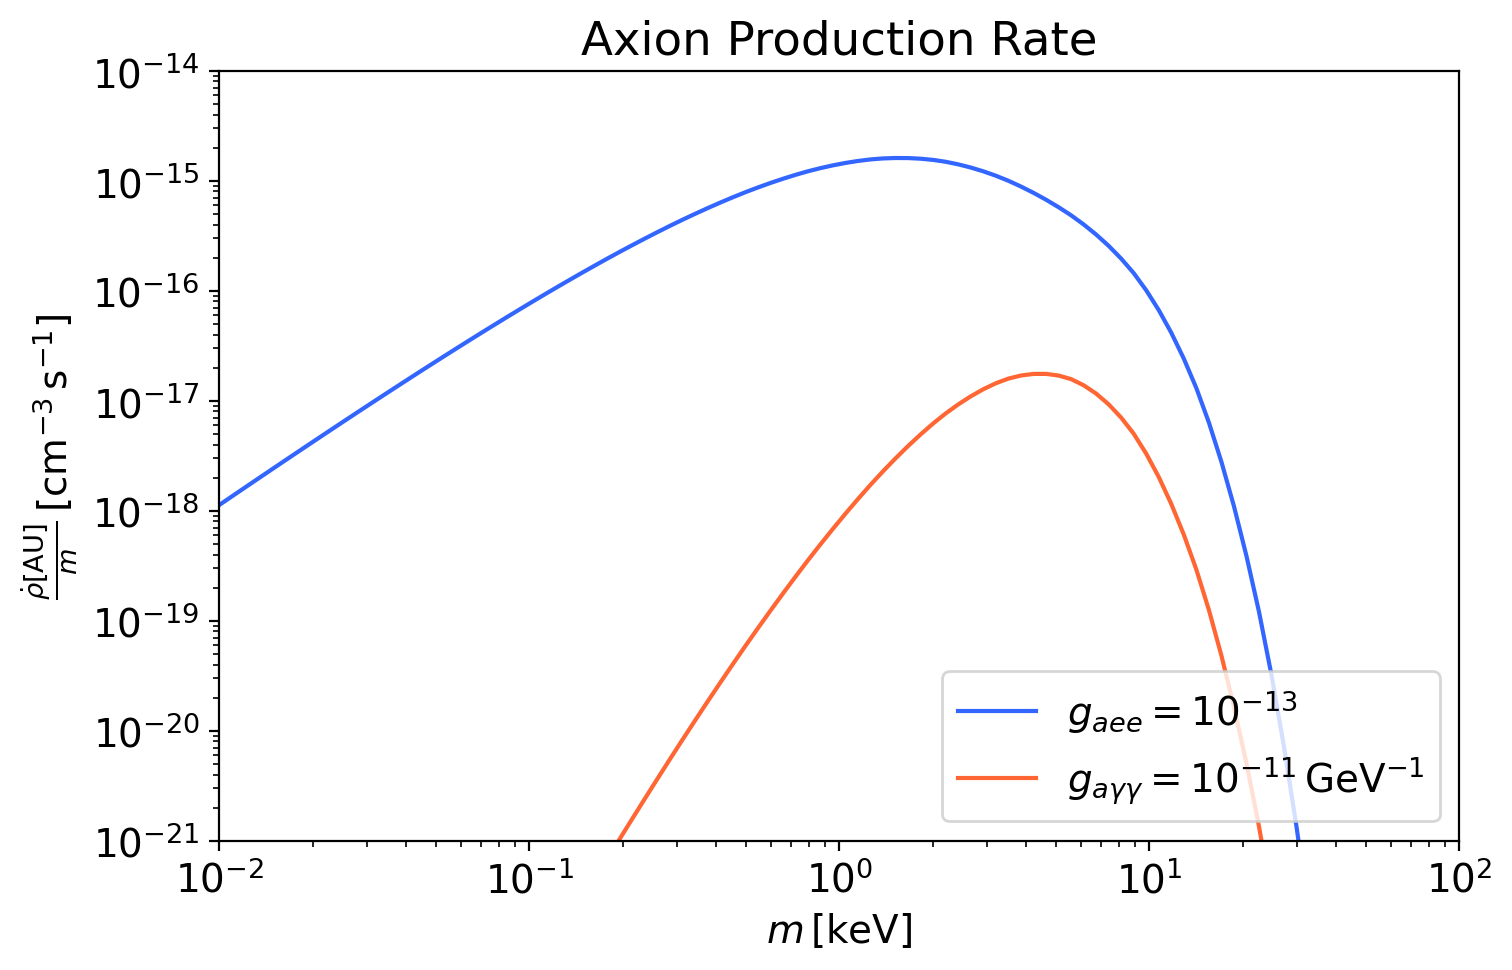

In [53]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 1e-13, 0)/(CentiMeter**-3 * Second**-1),color = (0.2,0.4,1), label=r'$g_{aee} = 10^{-13}$');
ax.plot(list_m,fn_rho_dot_over_m(list_m * keV, 0, 1e-11*GeV**-1)/(CentiMeter**-3 * Second**-1), color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.01,100);
ax.set_ylim(1e-21,1e-14);
ax.set_ylabel(r'$\frac{\dot{\rho}[\mathrm{AU}]}{m} \, [\mathrm{cm^{-3} \, s^{-1}}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion Production Rate'); ax.legend();

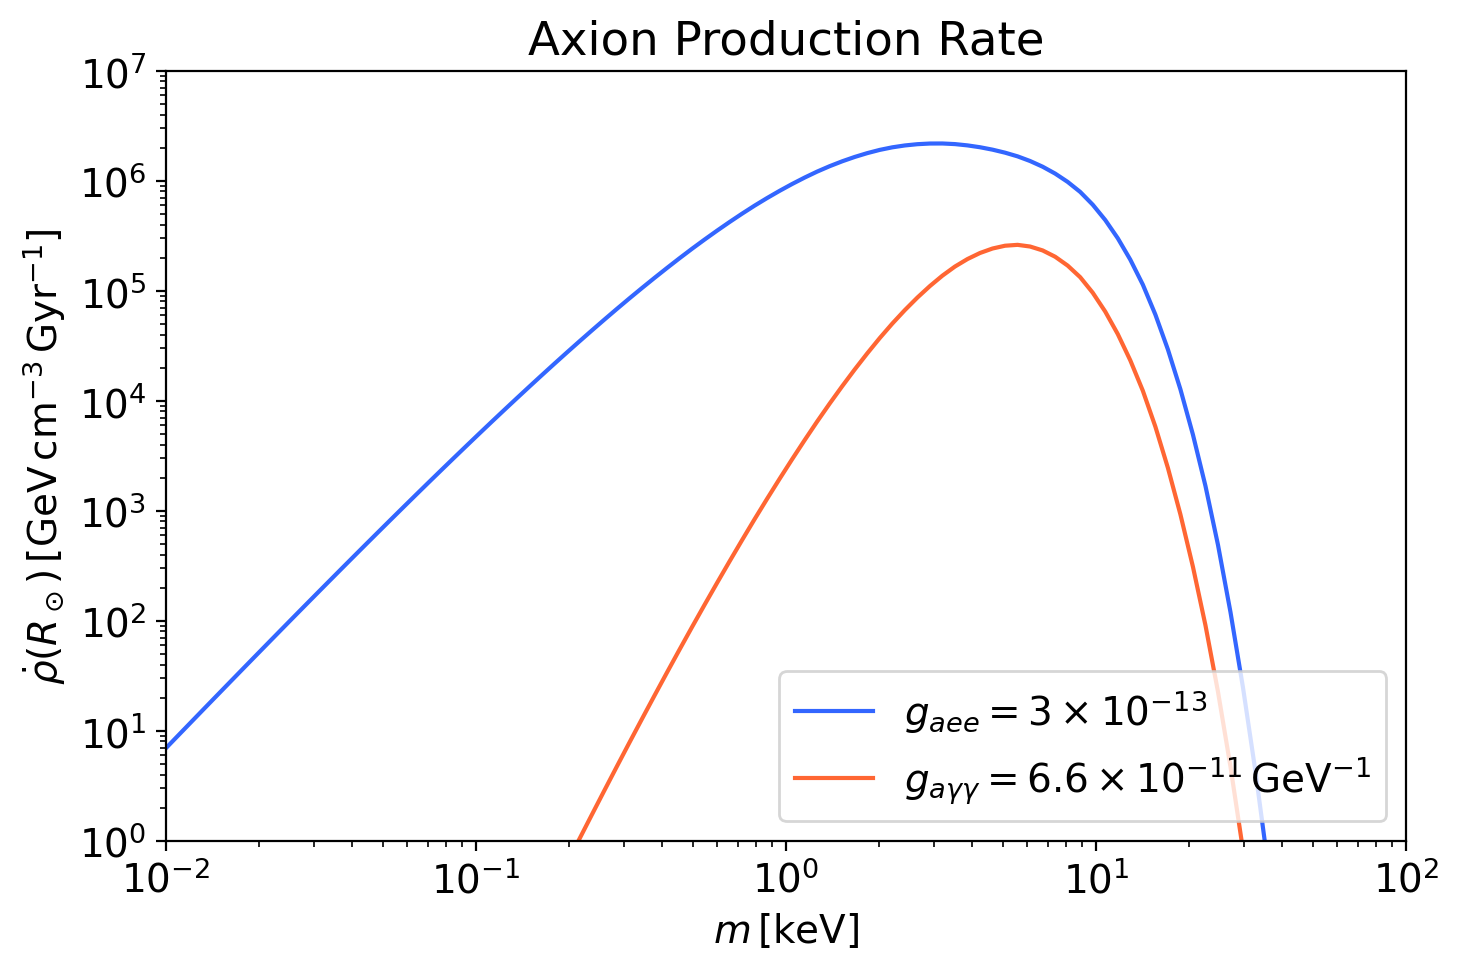

In [55]:
fig_rho_dot, ax = plt.subplots(1,1,figsize=(8,5))
list_m = np.logspace(np.log10(0.01),np.log10(100),100)
ax.plot(list_m,(AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 3e-13, 0)/(GeV * CentiMeter**-3 * 10**-9 * Year**-1),
        color = (0.2,0.4,1), label=r'$g_{aee} = 3 \times 10^{-13}$');
ax.plot(list_m,(AU/RSolar)**4 * (list_m * keV) * fn_rho_dot_over_m(list_m * keV, 0, 6.6e-11*GeV**-1)/(GeV * CentiMeter**-3 * 10**-9 * Year**-1), 
        color = (1.,0.4,0.2), label=r'$g_{a\gamma\gamma} = 6.6 \times 10^{-11}\,\mathrm{GeV}^{-1}$');
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlim(0.01,100);
ax.set_ylim(1e0,1e7);
ax.set_ylabel(r'$\dot{\rho}(R_\odot) \, [\mathrm{GeV \, cm^{-3} \, Gyr^{-1}}]$'); 
ax.set_xlabel(r'$m \, [\mathrm{keV}]$');
ax.set_title('Axion Production Rate'); ax.legend();

In [56]:
fig_rho_dot.savefig(FigDir+'rho_dot.pdf',bbox_inches='tight',pad_inches=0.02);

### Total signal

$$
F(\theta, \phi, E) =  B_0[m] e^{-(E-m/2)/T_0[m]} + \frac{1}{\sqrt{2\pi \sigma_E^2}}\exp\left\lbrace{-\frac{(E-m/2)^2}{2\sigma_E^2}}\right\rbrace S[m] T(\theta)
$$

In [57]:
def K_signal(m,gaee,gagg):
    """Signal count rate per unit area and per solid angle on the celestial sphere, in the center of the Sun (theta = 0). 
    Units: m [keV], gagg [GeV^-1]"""
    factor_prod = fn_rho_dot_over_m(m,gaee,gagg) / (6*np.pi) * AU**4 * RSolar**-3
    factor_decay = (1 - np.exp(-Gamma_rad(m,gagg,gaee) * tau_SS))
    return factor_prod * factor_decay

In [58]:
K_signal(10 * keV,1e-13,1e-12*GeV**-1) / Meter**-2 / Second**-1 * arcsec**2

0.00011515641509807726

\begin{align}
K[m,g_{aee},g_{agg}] &= \frac{\dot\rho_\mathrm{b}[\mathrm{AU}]}{6\pi m} \frac{\mathrm{AU}^4}{R_\odot^3} \left(1 - e^{-\Gamma_\mathrm{rad} \tau_\mathrm{SS}} \right)  \\
\frac{\mathrm{d} N}{\mathrm{d}t \, \mathrm{d}E \, \mathrm{d} \Omega} &= A \epsilon[t,E=m/2,\theta,\phi] \frac{1}{\sqrt{2\pi \sigma_E^2}}\exp\left\lbrace{-\frac{(E-m/2)^2}{2\sigma_E^2}}\right\rbrace K[m,g_{aee},g_{agg}] T(\theta)
\end{align}

In [59]:
10**6 * GeV * CentiMeter**-3 * (1e9 * Year)**-1 * RSolar / (6 * np.pi * (10 * keV)) / (Second**-1 * CentiMeter**-2 * arcsec**-2)

2.7500803457334065e-07

## Detector efficiencies and area

### From data

Load ARF:

In [60]:
list_arf = [file for file in list_files if file[-7:]=='arf.csv']
list_arf

['nu80610202001A06_arf.csv', 'nu80610202001B06_arf.csv']

In [61]:
list_arf_E = [[],[]]; list_arf_A = [[],[]];
for i,file in enumerate(list_arf):
    print(file)
    table = pd.read_csv(DataDir+'ORBIT_1/'+file)
    list_arf_E[i] = np.asarray(table['# Start of Energy Bin (keV)'])
    list_arf_A[i] = np.asarray(table[' Effective Area (cm^2)'])

nu80610202001A06_arf.csv
nu80610202001B06_arf.csv


In [62]:
arf_E = list_arf_E[0]
arf_A = np.sum(list_arf_A,axis=0)
int_arf = interp1d(arf_E, arf_A * CentiMeter**2,bounds_error=False,fill_value=0)

In [63]:
def eff_area(E):
    """Effective area (A and B combined) in units of cm^2 as a function of area."""
    return int_arf(E/keV)

In [64]:
eff_area(50*keV)/CentiMeter**2

44.336630003247215

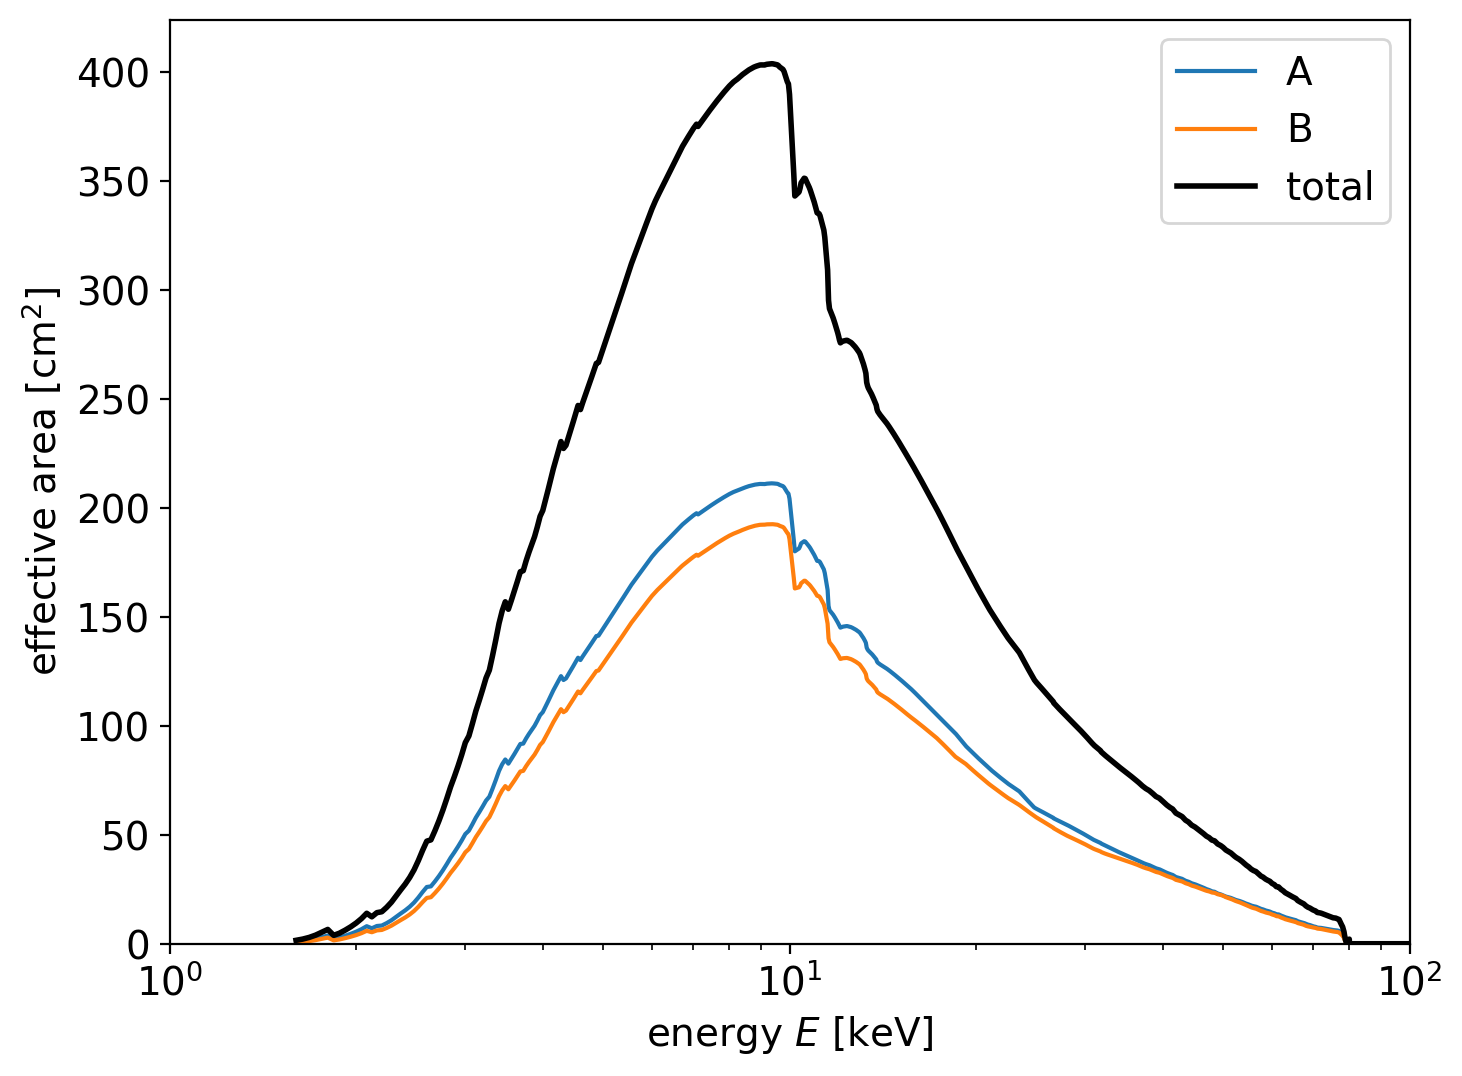

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
for i in range(len(list_arf)):
    ax.plot(list_arf_E[i], list_arf_A[i]);
ax.plot(arf_E, arf_A,lw=2,color='black');
ax.set_xlim(1,100); ax.set_ylim(0,);
ax.set_xlabel('energy $E$ [keV]'); ax.set_ylabel('effective area [$\mathrm{cm}^2$]');
ax.set_xscale('log');
ax.legend(['A','B','total']);

# Poisson Limit

## Total Expected Signal

$$ N_\mathrm{signal}[m,g_{aee},g_{agg}] = A K[m,g_{aee},g_{agg}] \int \mathrm{d}\Omega \, \mathrm{dt} \, \epsilon[t,E=m/2,\theta,\phi]  T(\theta)
$$

In [68]:
integral_Omega = 0;
list_xr = np.linspace(0,rect_XY_size,100);
list_yr = np.linspace(0,rect_XY_size,100); 
pix_size = (list_xr[1]-list_xr[0]) * (list_yr[1]-list_yr[0]) * arcsec**2

for xr in list_xr:
    for yr in list_yr:
        Xr = rect_XY_anchor[0] + np.cos(rect_XY_angle * degree) * xr - np.sin(rect_XY_angle * degree) * yr
        Yr = rect_XY_anchor[1] + np.sin(rect_XY_angle * degree) * xr + np.cos(rect_XY_angle * degree) * yr
        theta = XY_to_thetaphi(Xr,Yr)[0]
        integral_Omega += T_flux_template(theta) * pix_size 

In [69]:
np.sqrt(integral_Omega / arcsec**2)

1076.5962092314583

In [70]:
def N_signal(m,gaee,gagg):
    prefac = 0.68 #take only E within one sigma of m/2
    A = eff_area(m/2)
    integral_t = (np.max(t) - np.min(t))*Second
    sigma_E = 0.166 # in units of keV
    m_min = 2*(np.min(E)+sigma_E); # minimum mass two times above min(E) + 2 sigma_E
    m_max = 2*(np.max(E)-sigma_E); # maximum mass two times above max(E) - 2 sigma_E
    eps_m = np.where(np.asarray([m_min < m/keV, m/keV < m_max]).all(axis=0),1,0)
    return prefac * K_signal(m,gaee,gagg) * A * eps_m * integral_t * integral_Omega 

In [71]:
N_signal(10*keV,0,1e-10*GeV**-1)

42797.841849420394

In [72]:
N_signal(10*keV,1e-13,1e-10*GeV**-1)

56074.10189771115

In [73]:
N_signal(10*keV,1e-13,1e-12*GeV**-1)

8843.431740696566

In [74]:
N_signal(10*keV,1e-13,1e-14*GeV**-1)

1.455395685019494

## Total Recorded Data

$$ N_\mathrm{data}[m] = \sum_i^{\mathrm{data}} \Theta\left[1 - \frac{|E_i-m/2|}{\sigma_E} \right] $$

In [75]:
def N_data(m,sigma_E=0.166*keV):
    tmp = 0
    prob = np.heaviside(1 - np.abs(E * keV - m/2)/sigma_E,0)
    return np.sum(prob)

In [76]:
N_data(10*keV)

60.0

## Comparitive Plot

In [77]:
gaee = 10**-14; 
gagg = 10**-12 * GeV**-1; 

<ipython-input-49-9487a938c43c>:4: RuntimeWarning: divide by zero encountered in log10
  return (CentiMeter**-3 * Year**-1) * (gaee**2 * 10**int_rho_dot_over_m_e(np.log10(m/keV)) + (gagg * GeV)**2 * 10**int_rho_dot_over_m_gamma(np.log10(m/keV)))


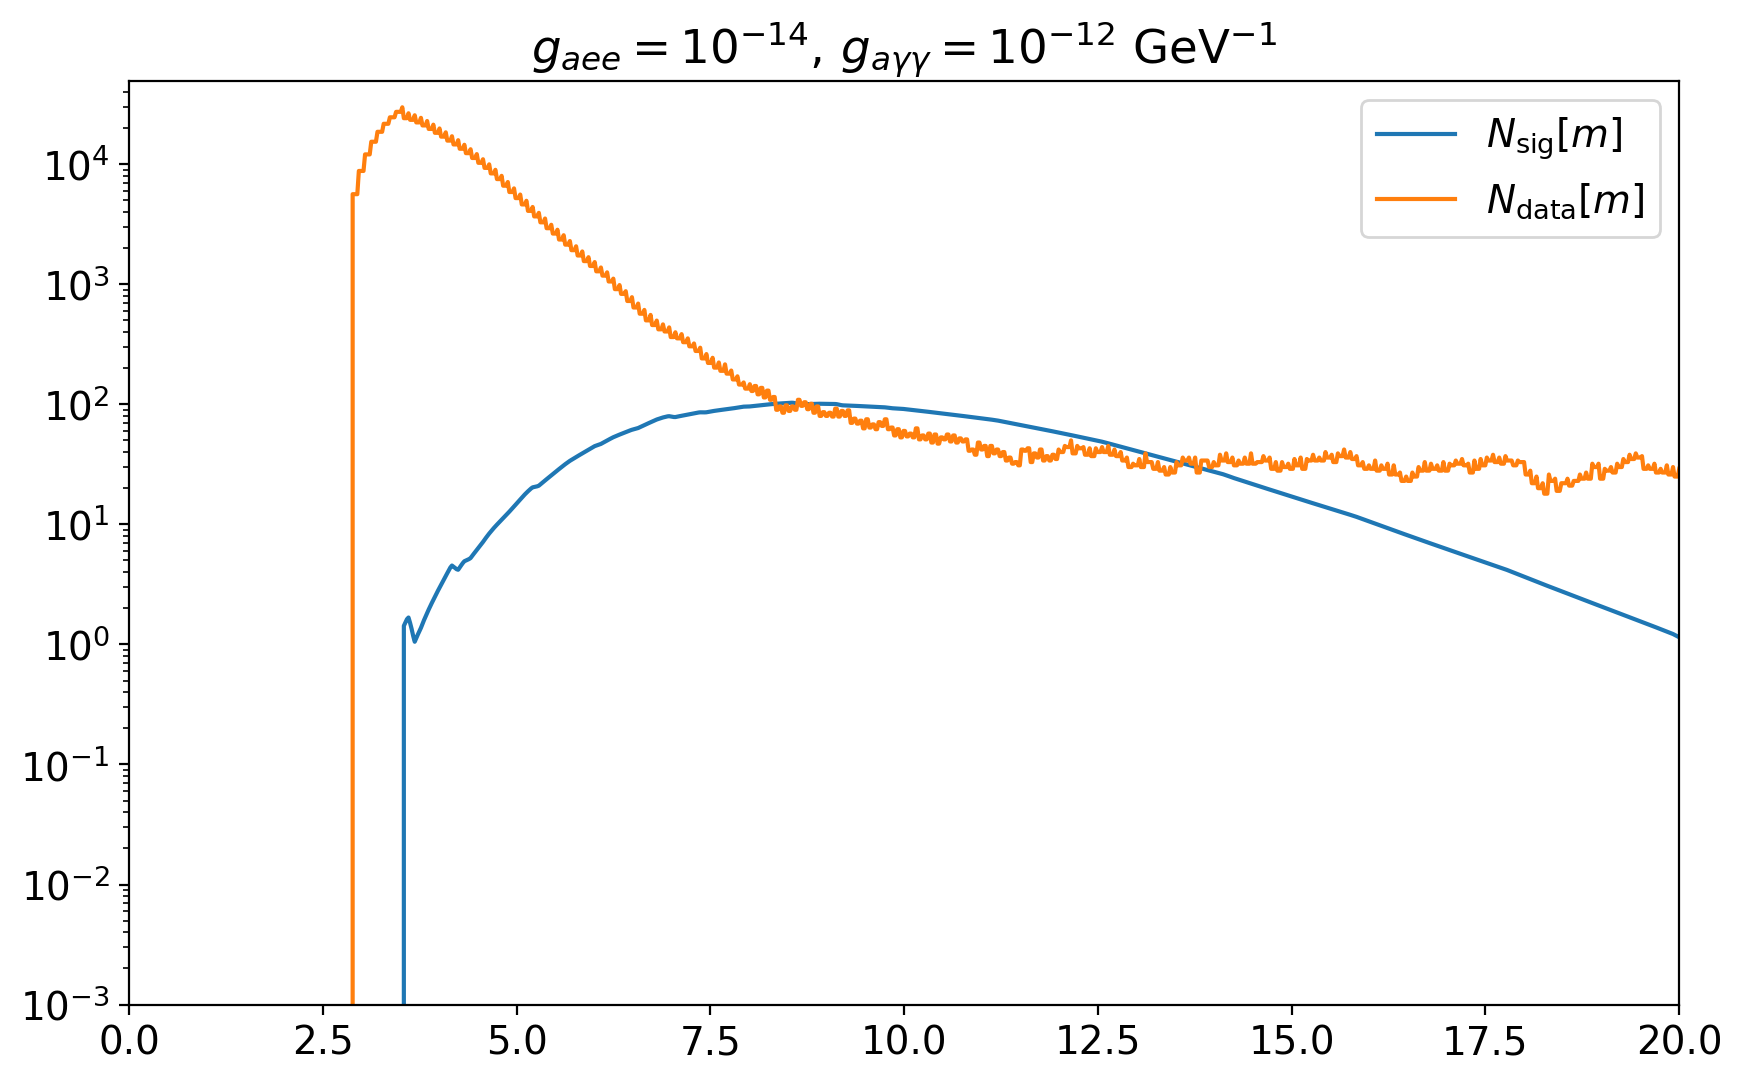

In [78]:
list_m = np.linspace(0,20,1000) * keV
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(list_m/keV,N_signal(list_m,gaee,gagg),label='$N_\mathrm{sig}[m]$')
ax.plot(list_m/keV,[N_data(m) for m in list_m],label='$N_\mathrm{data}[m]$')
ax.set_yscale('log');
ax.set_ylim(1e-3,);ax.set_xlim(list_m[0]/keV,list_m[-1]/keV);
ax.set_title('$g_{aee} = 10^{-14}, \, g_{a\gamma\gamma} = 10^{-12}~\mathrm{GeV}^{-1}$')
ax.legend();

## Other Constraints

### Electron constraints

In [79]:
def lim_extrapolate(m,T):
    s = m/T;
    def integrand(x):
        if x < 100:
            return x**2 * (x**2 - s**2)**(1/2) / (np.exp(x)-1)
        else:
            return 0
    
    integral = quad(integrand,s,np.max([1e3,1e3*s]))[0]
    prefac = (np.pi**4/15)**-1
    return np.max([1e-100,np.sqrt(prefac * integral)])

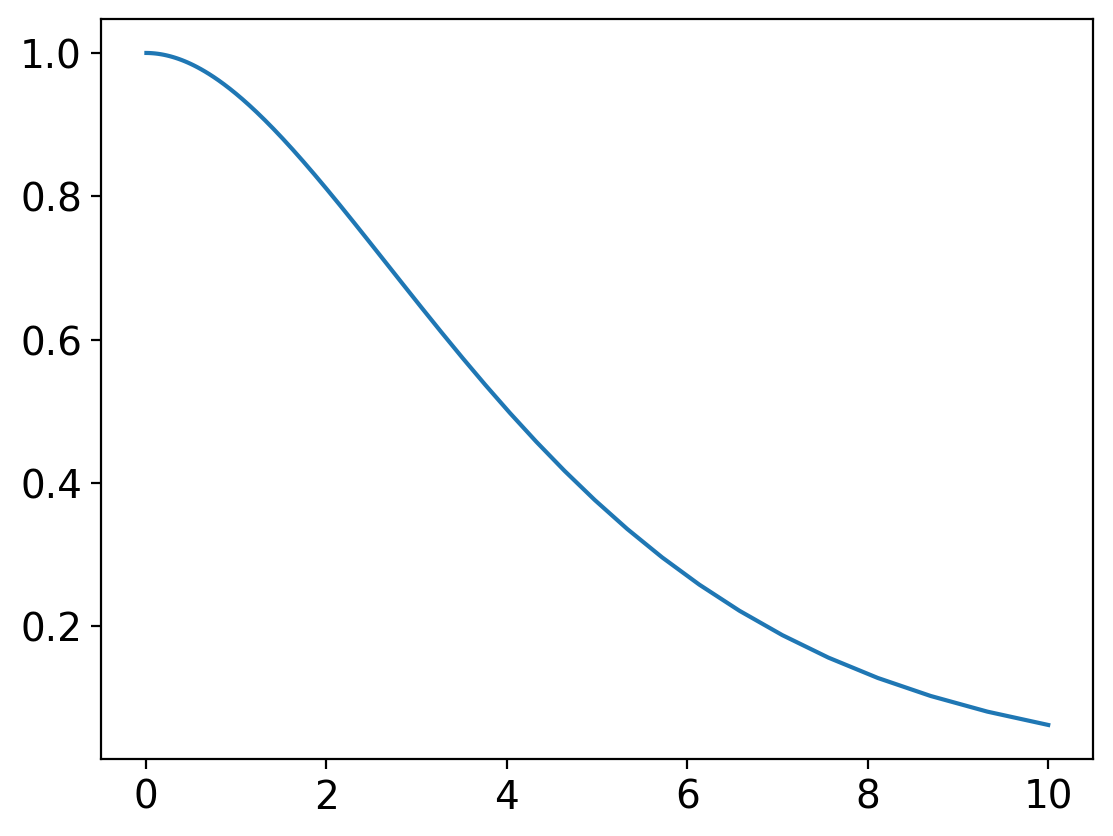

In [80]:
list_m = np.logspace(-2,1,100)
plt.plot(list_m,[lim_extrapolate(m,1) for m in list_m])

In [81]:
def gaee_lim_WD(m,T=10**7 * Kelvin):
    lim_0 = 3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [82]:
def gaee_lim_RG(m,T=10**8 * Kelvin):
    lim_0 = 4.3 * 10**-13
    return lim_0 / lim_extrapolate(m,T)

In [83]:
lim_extrapolate(1e-2,1)

0.9999936725460565

### Photon constraints

In [84]:
def gagg_lim_HB(m,T=10**8 * Kelvin):
    lim_0 = 6.6 * 10**-11 * GeV**-1
    return lim_0 / lim_extrapolate(m,T)

In [85]:
gagg_lim_HB(1e-2*keV)/GeV**-1

6.600000564987312e-11

In [86]:
lim_extrapolate(60*keV,10**8 * Kelvin)

0.19276519610258389

## Limit

### Poisson function

In [87]:
def poisson_limit(N_dat,CL=0.9):
    N_sig = np.logspace(0,8,np.int(1e5))
    idx = np.argwhere(np.diff(np.sign((1-CL) - stats.poisson.cdf(N_dat,N_sig)))).flatten()[0]
    return N_sig[idx]

In [88]:
poisson_limit(0),poisson_limit(100)

(2.302309055277051, 114.06189206392084)

### Limit contours at fixed mass

In [89]:
from shapely import geometry

def findIntersection(contour1,contour2):
  p1 = contour1.collections[0].get_paths()[0]
  v1 = p1.vertices

  p2 = contour2.collections[0].get_paths()[0]
  v2 = p2.vertices

  poly1 = geometry.LineString(v1)
  poly2 = geometry.LineString(v2)

  intersection = poly1.intersection(poly2)

  return intersection

In [90]:
#list_m = keV * np.logspace(-1,2,np.int(1e2))
list_m = keV * np.concatenate([np.arange(4.0,10,2),np.arange(10.,20,5.),np.arange(20.0,40.,10.)])
list_gaee = np.logspace(-16,-11,np.int(2e2))
list_gagg = GeV**-1 * np.logspace(-15,-8,np.int(3e2))
arr_N_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg)

100%|██████████| 7/7 [01:11<00:00, 10.25s/it]


In [91]:
arr_N_data = np.zeros(len(list_m));
arr_N_limit = np.zeros(len(list_m));
for i_m, m in enumerate(list_m):
    arr_N_data[i_m] = N_data(m)
    arr_N_limit[i_m] = poisson_limit(N_data(m))
arr_N_data, arr_N_limit

(array([19839.,  1530.,   147.,    60.,    29.,    29.,    25.]),
 array([20017.1855099 ,  1581.21887517,   163.78048114,    71.18992316,    37.19595426,    37.19595426,    32.70808717]))

In [92]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

In [93]:
arr_prod_ratio = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_prod_ratio[i_m,i_e,i_g] = fn_rho_dot_over_m(m,0,gagg)/fn_rho_dot_over_m(m,gaee,0)

100%|██████████| 7/7 [00:30<00:00,  4.36s/it]


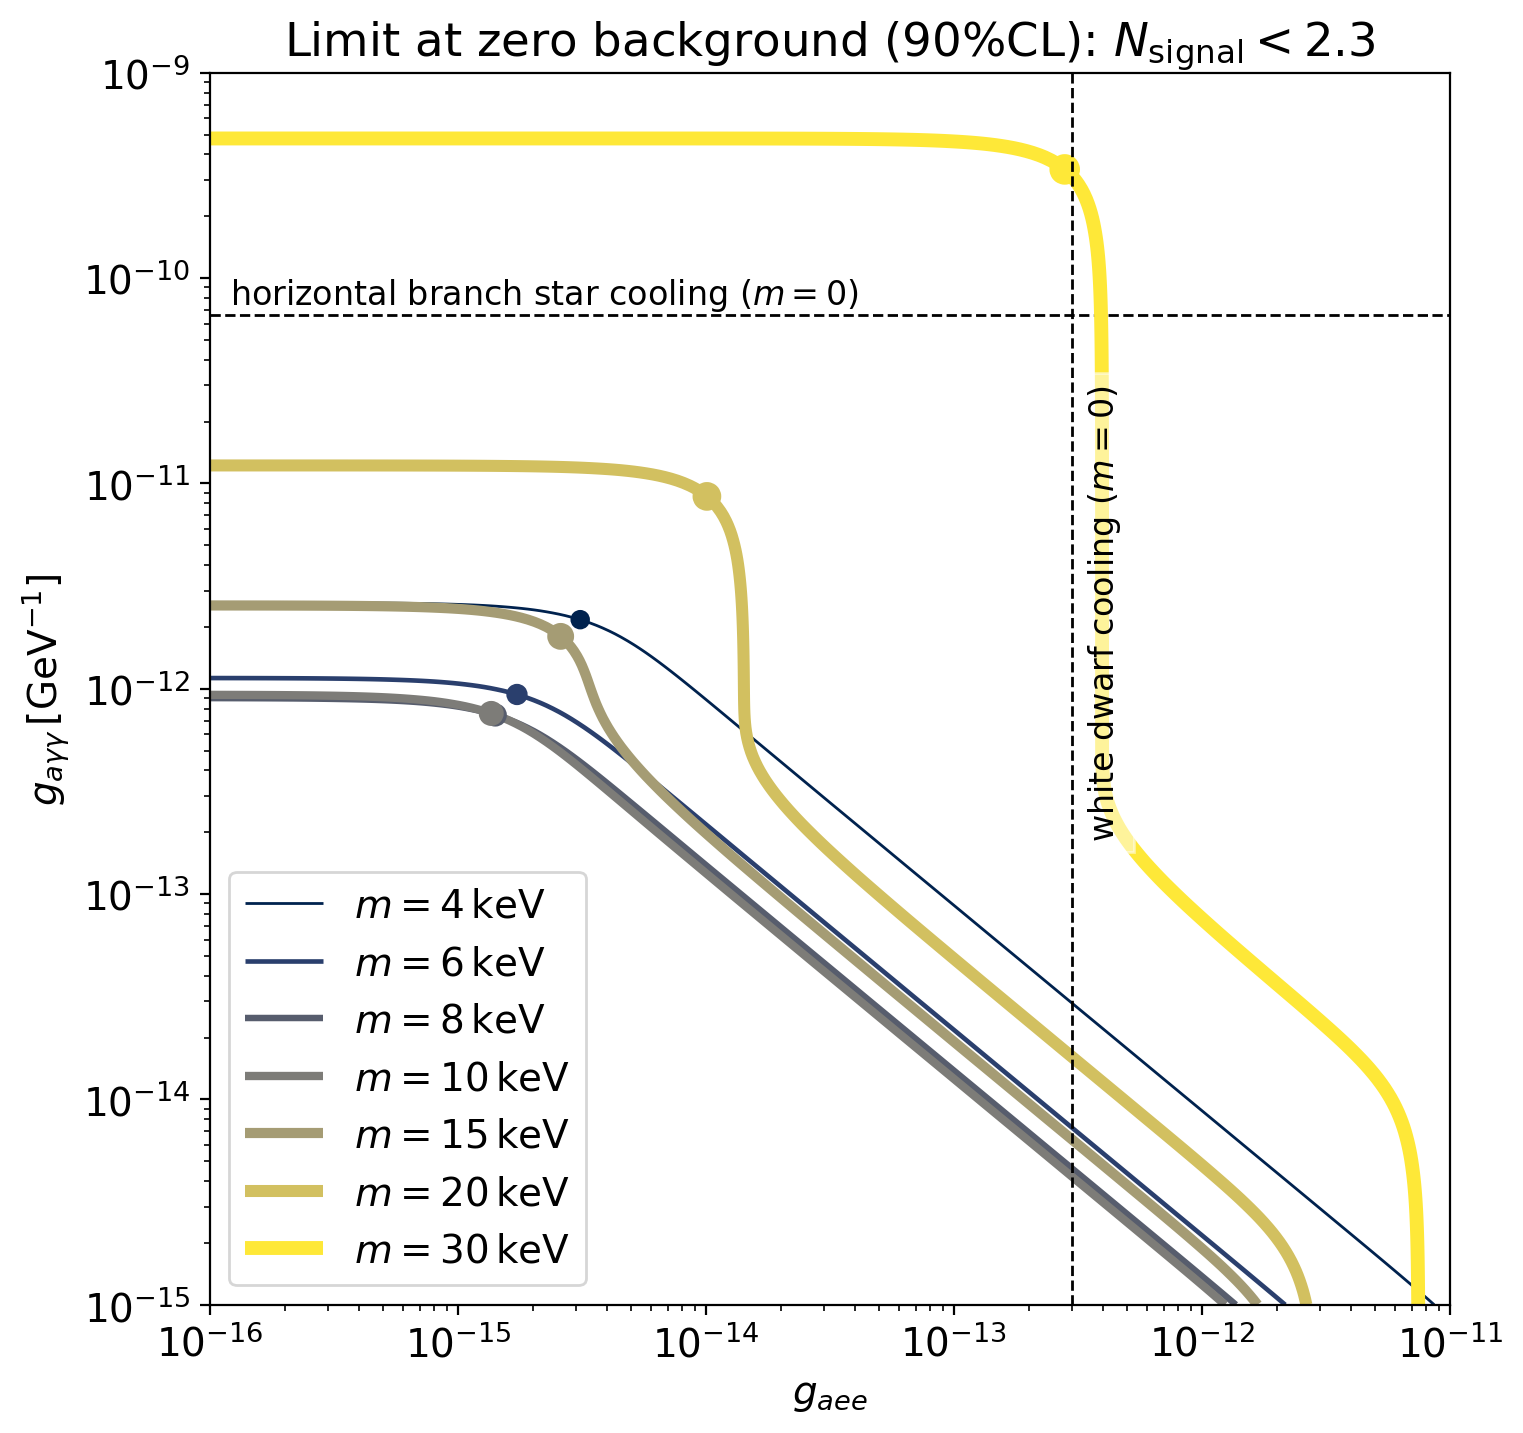

In [94]:
cmap = mpl.cm.get_cmap('cividis')
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 4 \, \mathrm{keV}$','$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$','$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$',
           '$m = 30 \, \mathrm{keV}$','$m = 40 \, \mathrm{keV}$']
fig_lim1, ax = plt.subplots(1,1,figsize=(8,8))
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_N_signal[i_m])),levels=[np.log10(poisson_limit(0))],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_prod_ratio[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],#colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.text(3.4e-13,2e-13,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));

In [95]:
fig_lim1.savefig(FigDir+'lim_m_contours_zero_bckg.pdf',bbox_inches='tight',pad_inches=0.02);

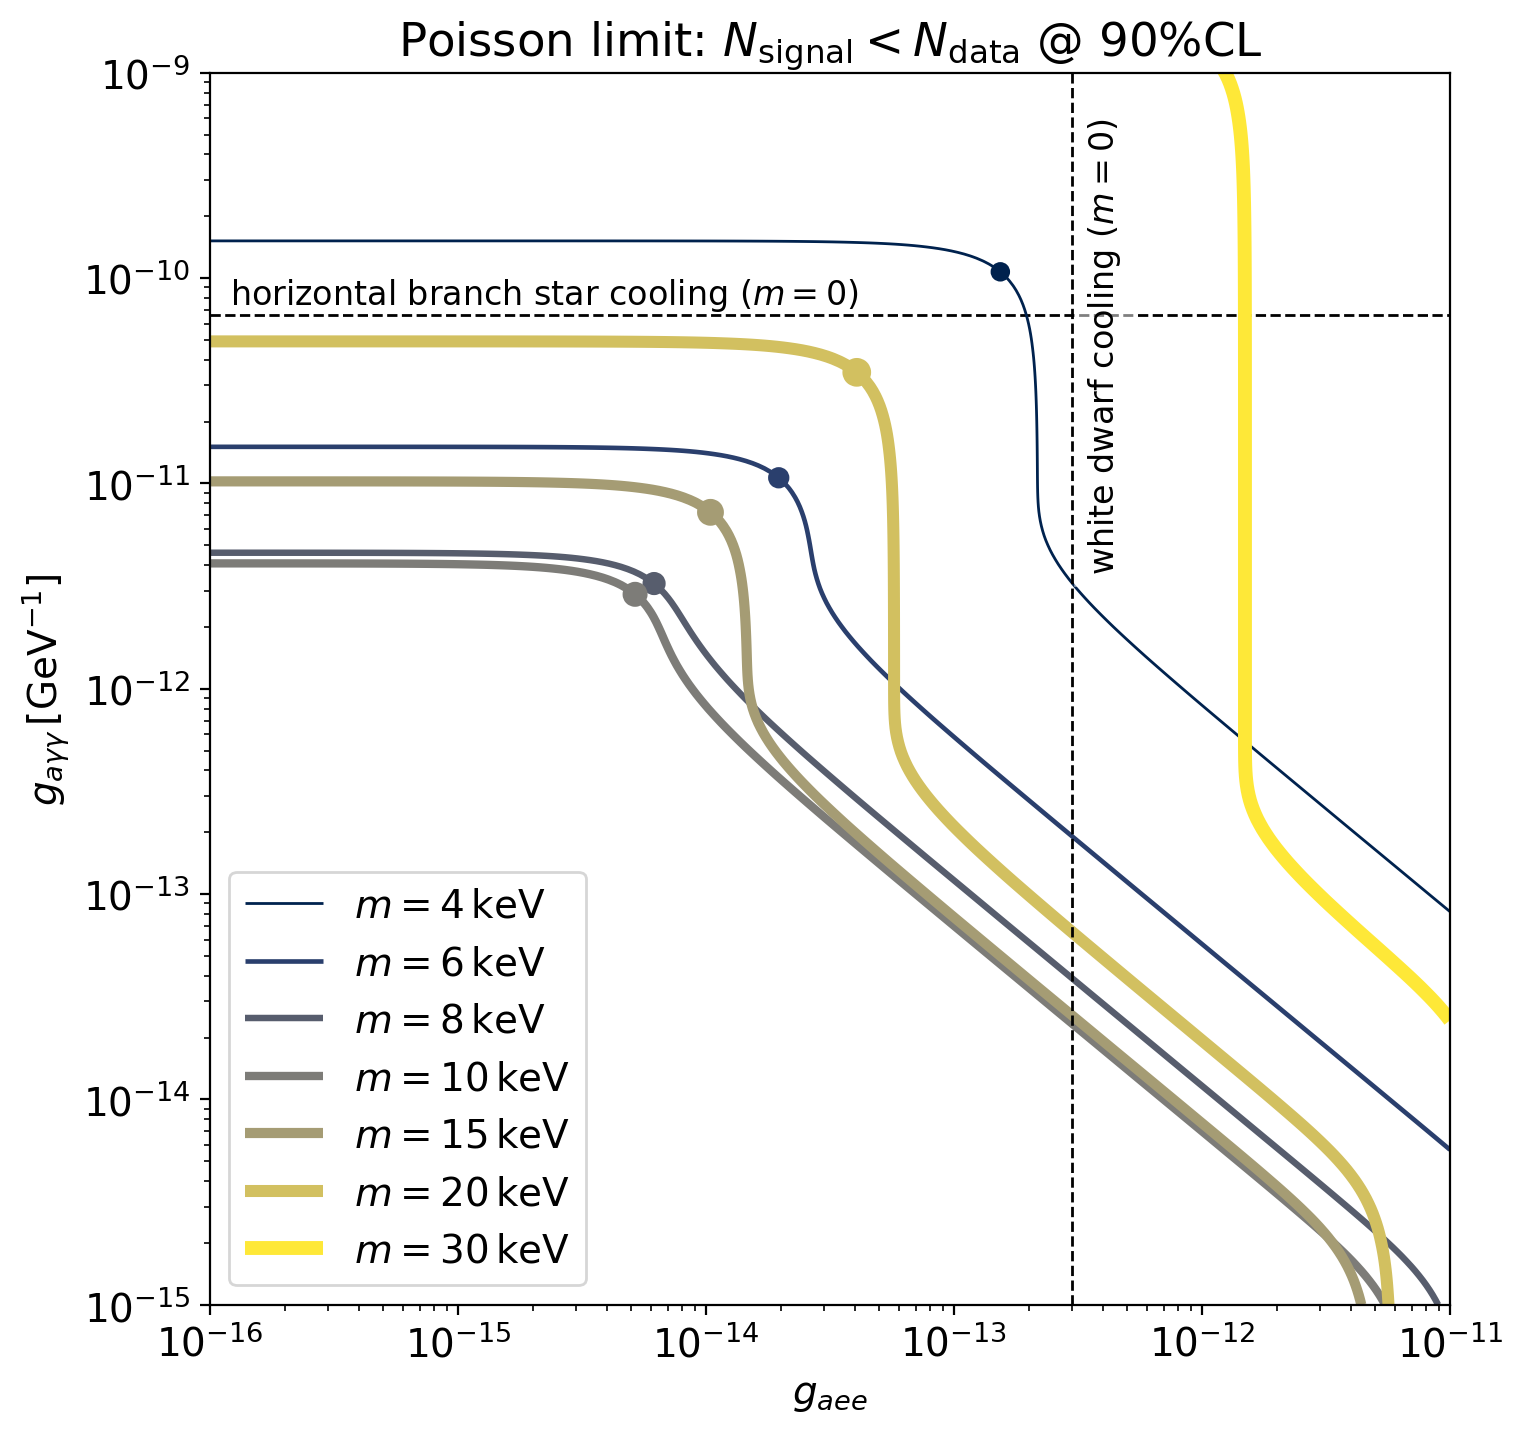

In [96]:
list_colors = cmap(np.linspace(0,1,len(list_m)))
list_lw = np.linspace(1,5,len(list_m))
labels = ['$m = 4 \, \mathrm{keV}$','$m = 6 \, \mathrm{keV}$','$m = 8 \, \mathrm{keV}$','$m = 10 \, \mathrm{keV}$','$m = 15 \, \mathrm{keV}$','$m = 20 \, \mathrm{keV}$',
           '$m = 30 \, \mathrm{keV}$','$m = 40 \, \mathrm{keV}$']
fig_lim2, ax = plt.subplots(1,1,figsize=(8,8))
ax.hlines(gagg_lim_HB(1e-2*keV)/GeV**-1,list_gaee[0],list_gaee[-1],ls='dashed',color='black',lw=1)
ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)

arr_intersection = np.zeros((len(list_m),2))
for i_m, m in enumerate(list_m):
    c1 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
    c2 = ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_prod_ratio[i_m])),levels=[np.log10(1)],
                    colors=[(1,1,1,0)],
                    #colors=[list_colors[i_m]],
                    linewidths = 0.5 * list_lw[i_m]);
    intersection = findIntersection(c1,c2)
    arr_intersection[i_m] = [intersection.x,intersection.y]
    #print(intersection.y/intersection.x, list(intersection.coords))
    ax.collections[2*i_m+1].set_label(labels[i_m])
ax.scatter(arr_intersection[:,0],arr_intersection[:,1],zorder=2,color=list_colors,lw=list_lw)
ax.set_xlim(1e-16,1e-11); ax.set_ylim(1e-15,1e-9);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$g_{aee}$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.text(3.4e-13,4e-12,'white dwarf cooling ($m=0$)',fontsize=12, rotation = 90, bbox=dict(edgecolor='white',facecolor='white', alpha=0.5));
ax.text(1.2e-16,7.5e-11,'horizontal branch star cooling ($m=0$)',fontsize=12,bbox=dict(edgecolor='white',facecolor='white', alpha=0));

In [97]:
fig_lim2.savefig(FigDir+'lim_m_contours_poisson.pdf',bbox_inches='tight',pad_inches=0.02);

### Pure Photon Coupling Limit

In [98]:
list_m = keV * np.logspace(np.log10(3),np.log10(40),np.int(3e2))
list_gaee = np.asarray([0,1e-14,1e-13,1e-12])
list_gagg = GeV**-1 * np.logspace(-15,-9,np.int(3e2))
arr_N_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg)+1e-100

100%|██████████| 300/300 [01:03<00:00,  4.76it/s]


In [99]:
arr_N_data = np.zeros(len(list_m));
arr_N_limit = np.zeros(len(list_m));
for i_m, m in enumerate(list_m):
    arr_N_data[i_m] = N_data(m)
    arr_N_limit[i_m] = poisson_limit(N_data(m))
#arr_N_data, arr_N_limit

In [100]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

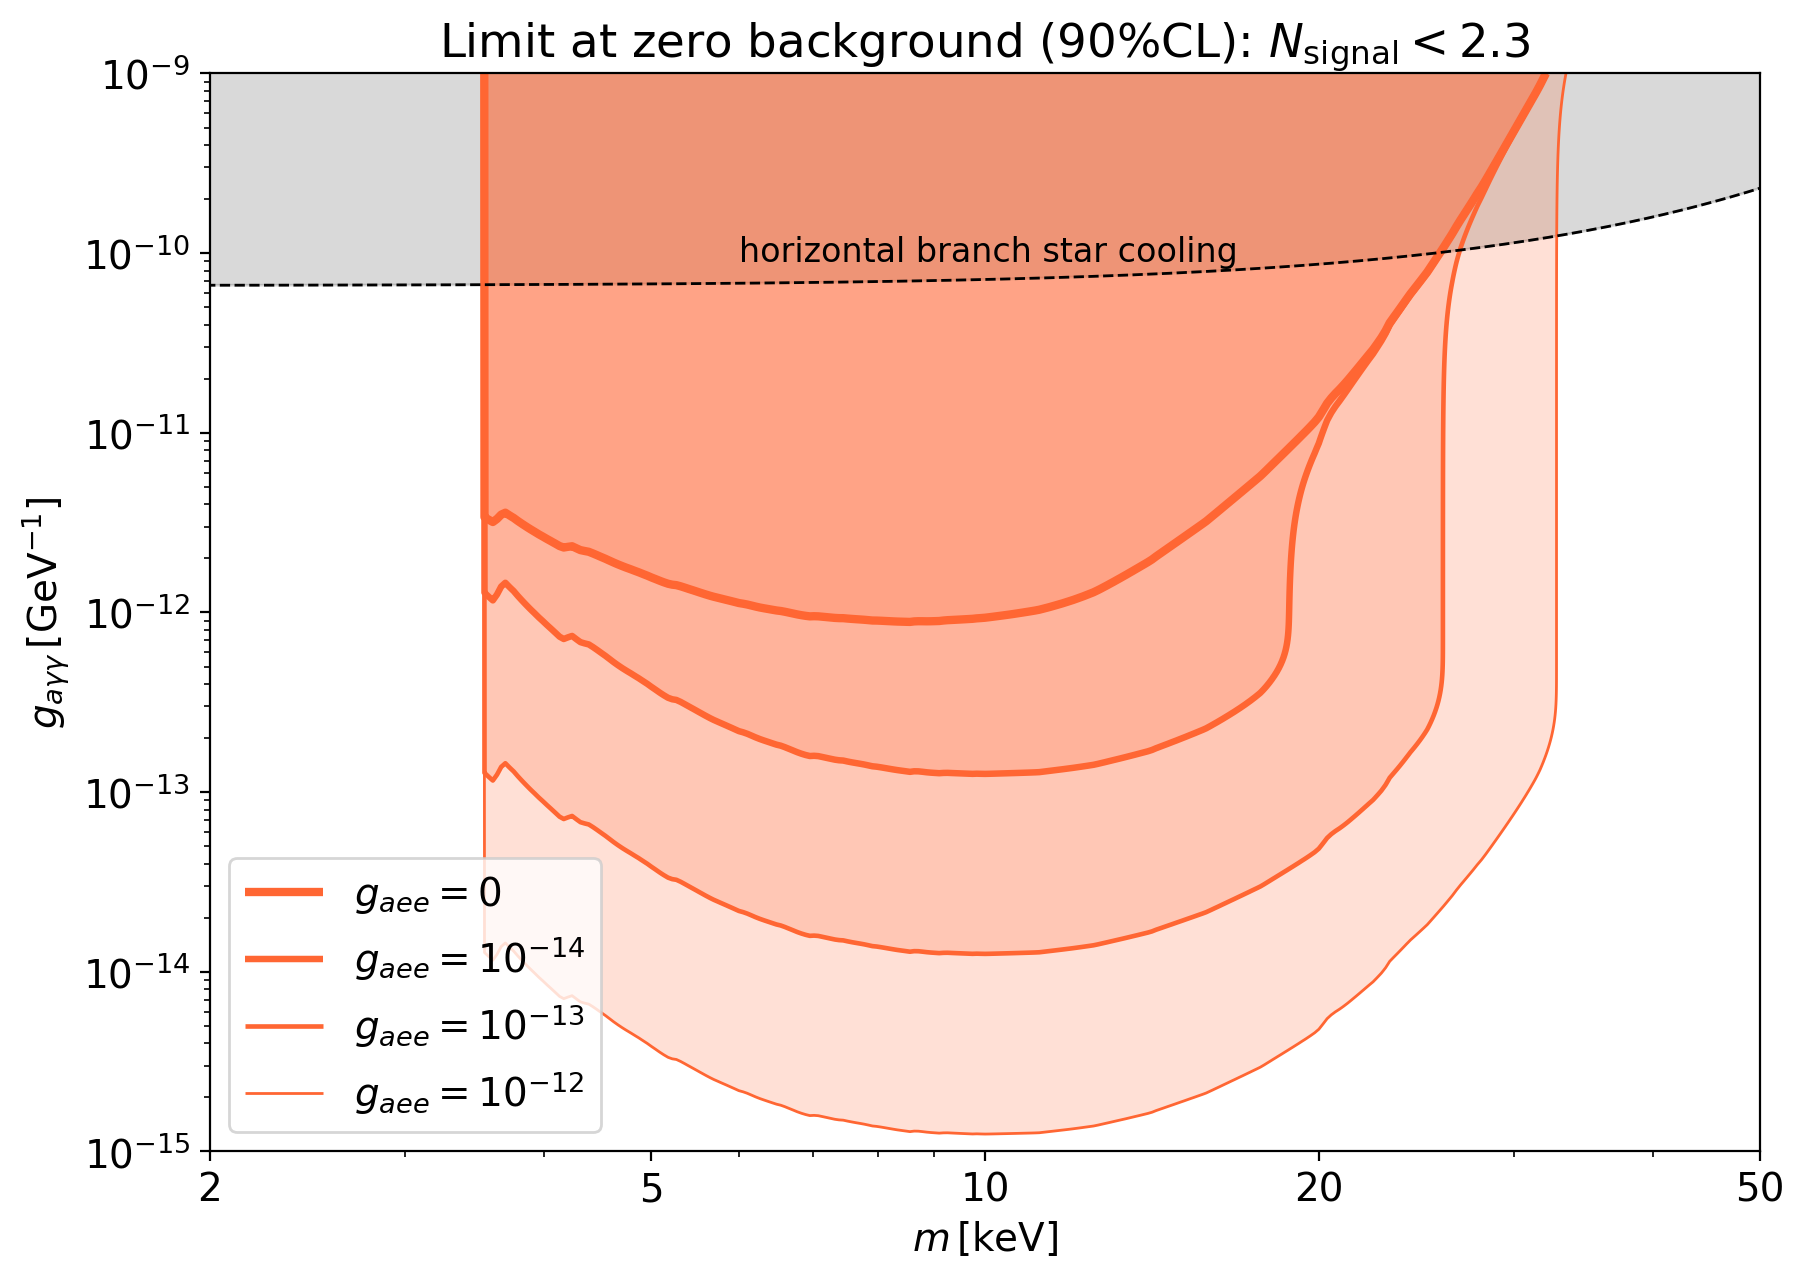

In [101]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot1, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_N_signal[:,i_e,:])),levels=[np.log10(poisson_limit(0))],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_N_signal[:,i_e,:])),levels=[np.log10(poisson_limit(0)),+30],colors=[(1.,0.4,0.2,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(list_gagg[0],list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [102]:
fig_lim_phot1.savefig(FigDir+'lim_photon_zero_background.pdf',bbox_inches='tight',pad_inches=0.02);

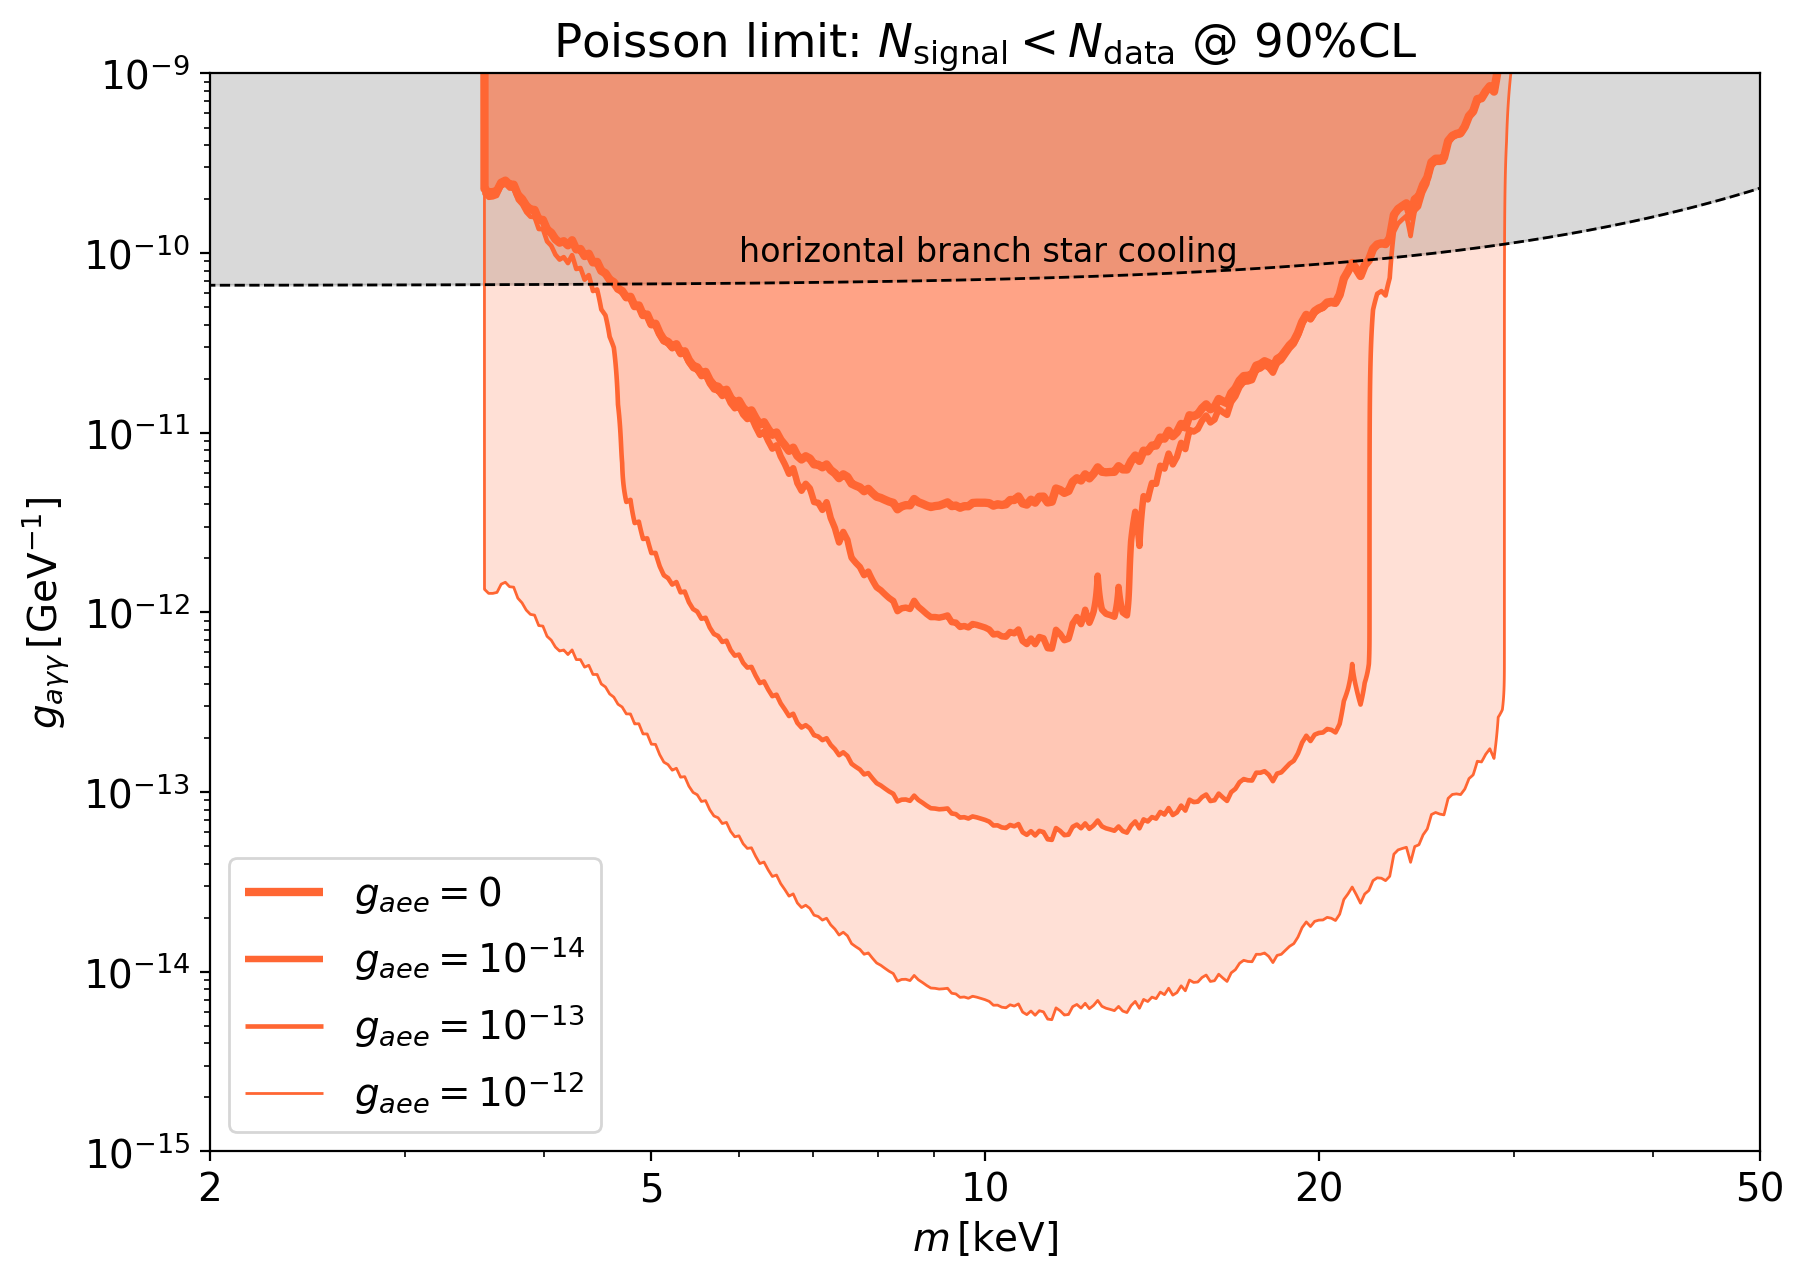

In [103]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot2, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0,+5],colors=[(1.,0.4,0.2,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(list_gagg[0],list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

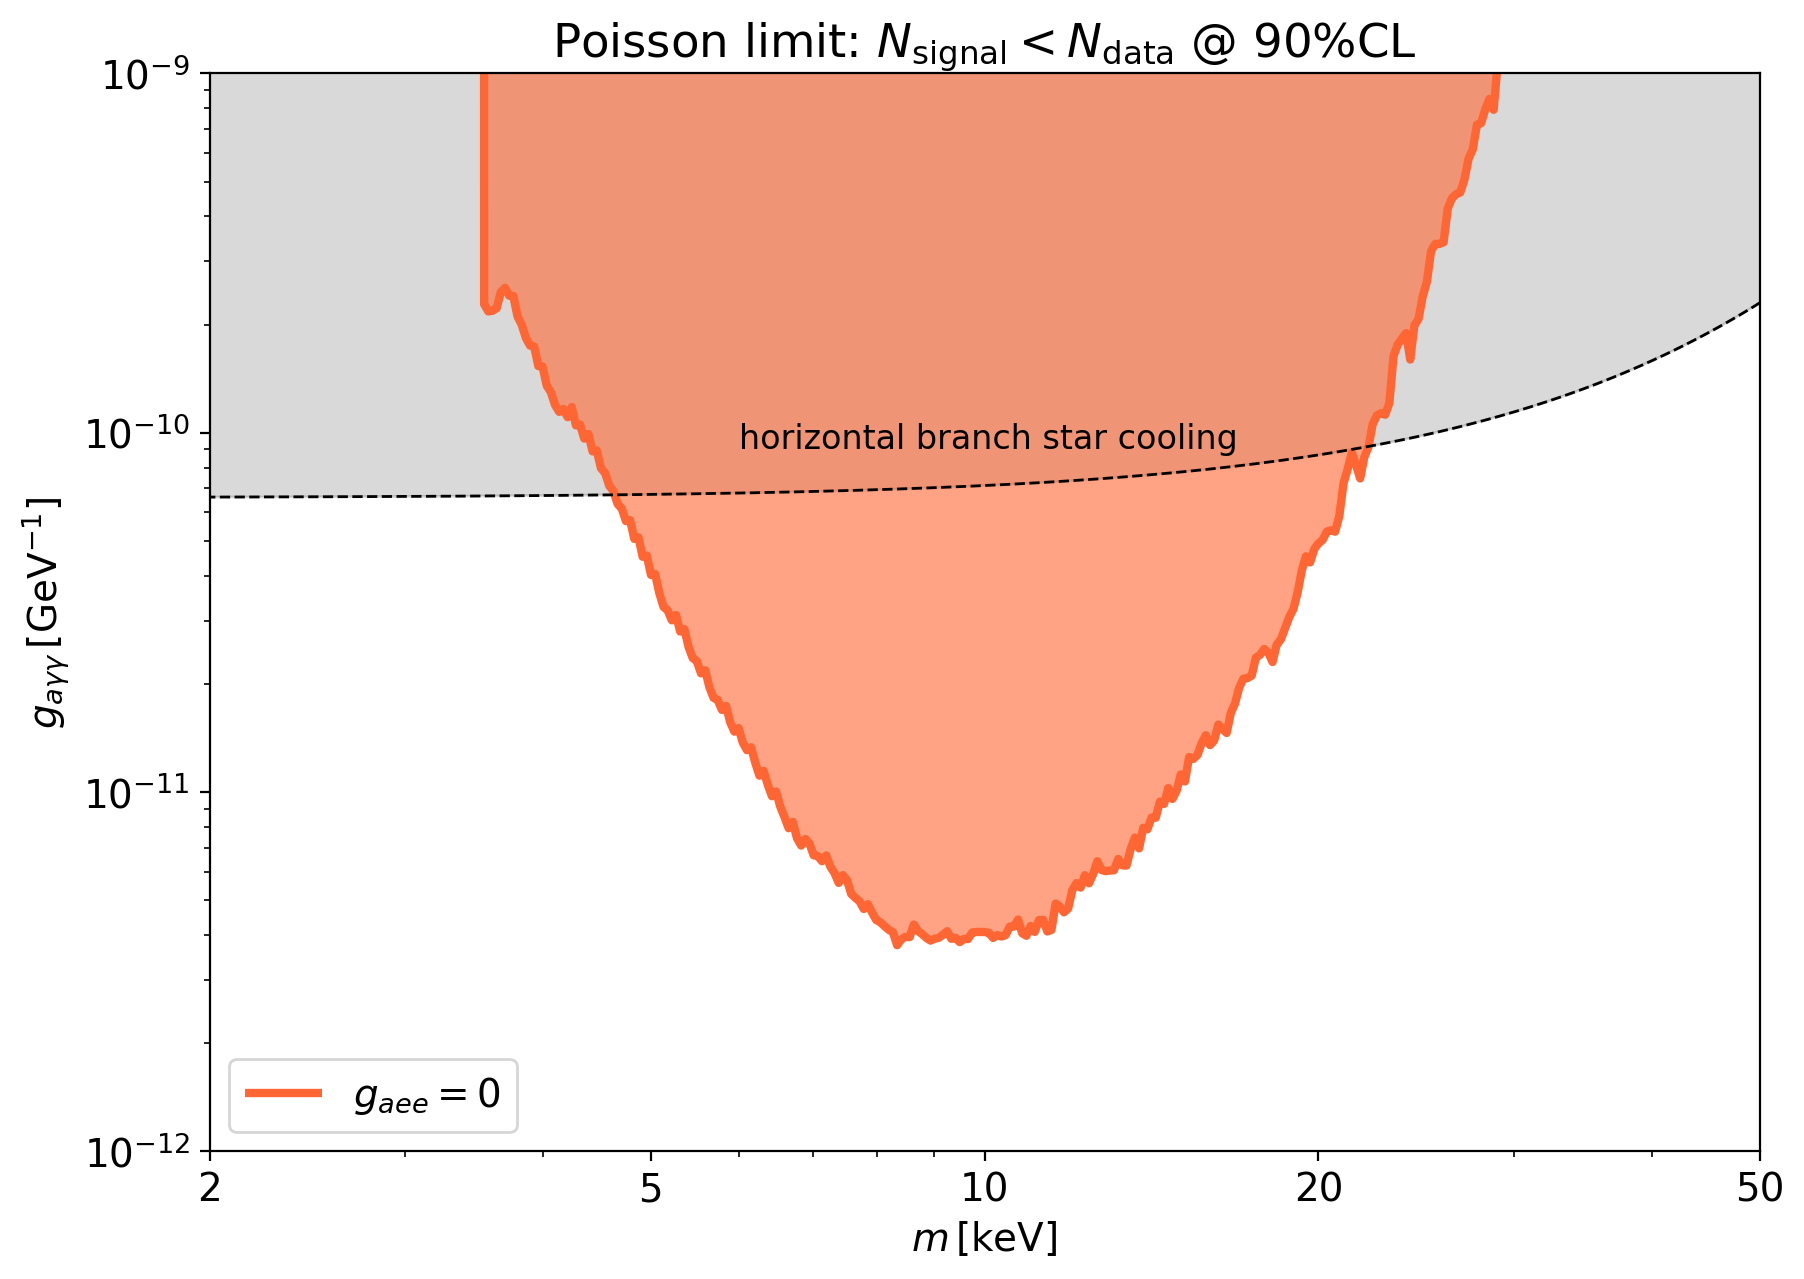

In [105]:
list_lw = np.linspace(3,1,len(list_gaee))
fig_lim_phot3, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gagg_lim_HB(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{aee} = 0$','$g_{aee} = 10^{-14}$','$g_{aee} = 10^{-13}$','$g_{aee} = 10^{-12}$']
for i_e, gaee in enumerate(list_gaee[0:1]):
    ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0],colors=[(1.,0.4,0.2)],linewidths=list_lw[i_e])
    ax.collections[i_e+1].set_label(labels[i_e])
for i_e, gaee in enumerate(list_gaee[0:1]):
    ax.contourf(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim[:,i_e,:])),levels=[0,+5],colors=[(1.,0.4,0.2,0.6)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(1e-12,list_gagg[-1]);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{a\gamma\gamma} \, [\mathrm{GeV}^{-1}]$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(6,9e-11,'horizontal branch star cooling',fontsize=12,bbox=dict(edgecolor=None,facecolor='white', alpha=0));

In [106]:
fig_lim_phot3.savefig(FigDir+'lim_photon_poisson_gaee0.pdf',bbox_inches='tight',pad_inches=0.02);

### Pure Electron Coupling Limit

In [107]:
list_m = keV * np.logspace(np.log10(3),np.log10(40),np.int(3e2))
list_gaee = np.logspace(-16,-10,np.int(2e2))
list_gagg = GeV**-1 * np.asarray([0,1e-14,1e-13,1e-12,1e-11,1e-10])
arr_N_signal = np.zeros((len(list_m),len(list_gaee),len(list_gagg)))
for i_m, m in enumerate(tqdm(list_m)):
    for i_e, gaee in enumerate(list_gaee):
        for i_g, gagg in enumerate(list_gagg):
            arr_N_signal[i_m,i_e,i_g] = N_signal(m,gaee,gagg)+1e-100

100%|██████████| 300/300 [01:03<00:00,  4.73it/s]


In [108]:
arr_N_data = np.zeros(len(list_m));
arr_N_limit = np.zeros(len(list_m));
for i_m, m in enumerate(list_m):
    arr_N_data[i_m] = N_data(m)
    arr_N_limit[i_m] = poisson_limit(N_data(m))
#arr_N_data, arr_N_limit

In [109]:
arr_poisson_lim = np.transpose(np.transpose(arr_N_signal)/arr_N_limit)

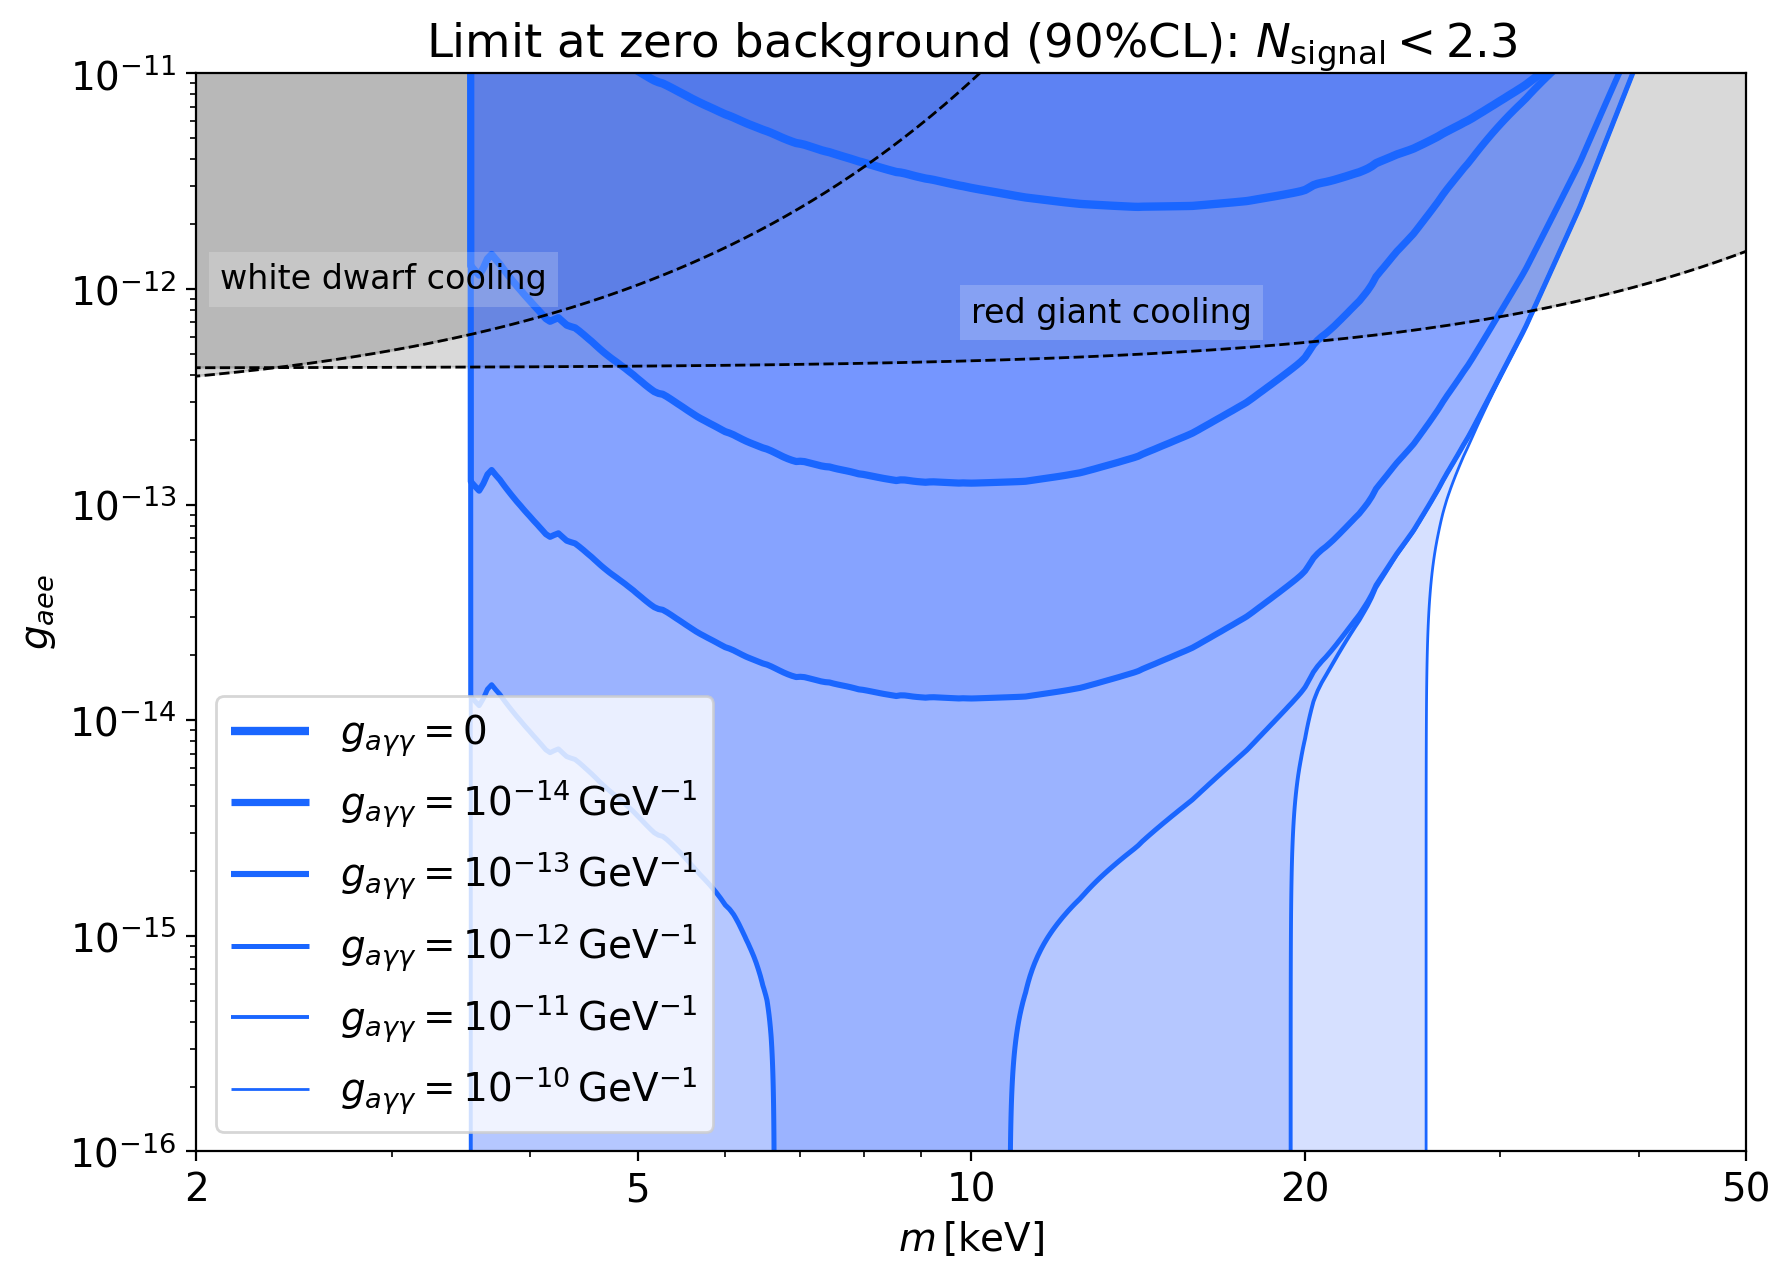

In [110]:
list_lw = np.linspace(3,1,len(list_gagg))
fig_lim_electron1, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(list_gagg):
    ax.contour(list_m/keV,list_gaee,np.log10(np.transpose(arr_N_signal[:,:,i_g])),levels=[np.log10(poisson_limit(0))],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(list_gagg):
    ax.contourf(list_m/keV,list_gaee,np.log10(np.transpose(arr_N_signal[:,:,i_g])),levels=[np.log10(poisson_limit(0)),+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Limit at zero background (90%CL): $N_\mathrm{signal} < 2.3$');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(2.1,1e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

In [111]:
fig_lim_electron1.savefig(FigDir+'lim_electron_zero_background.pdf',bbox_inches='tight',pad_inches=0.02);

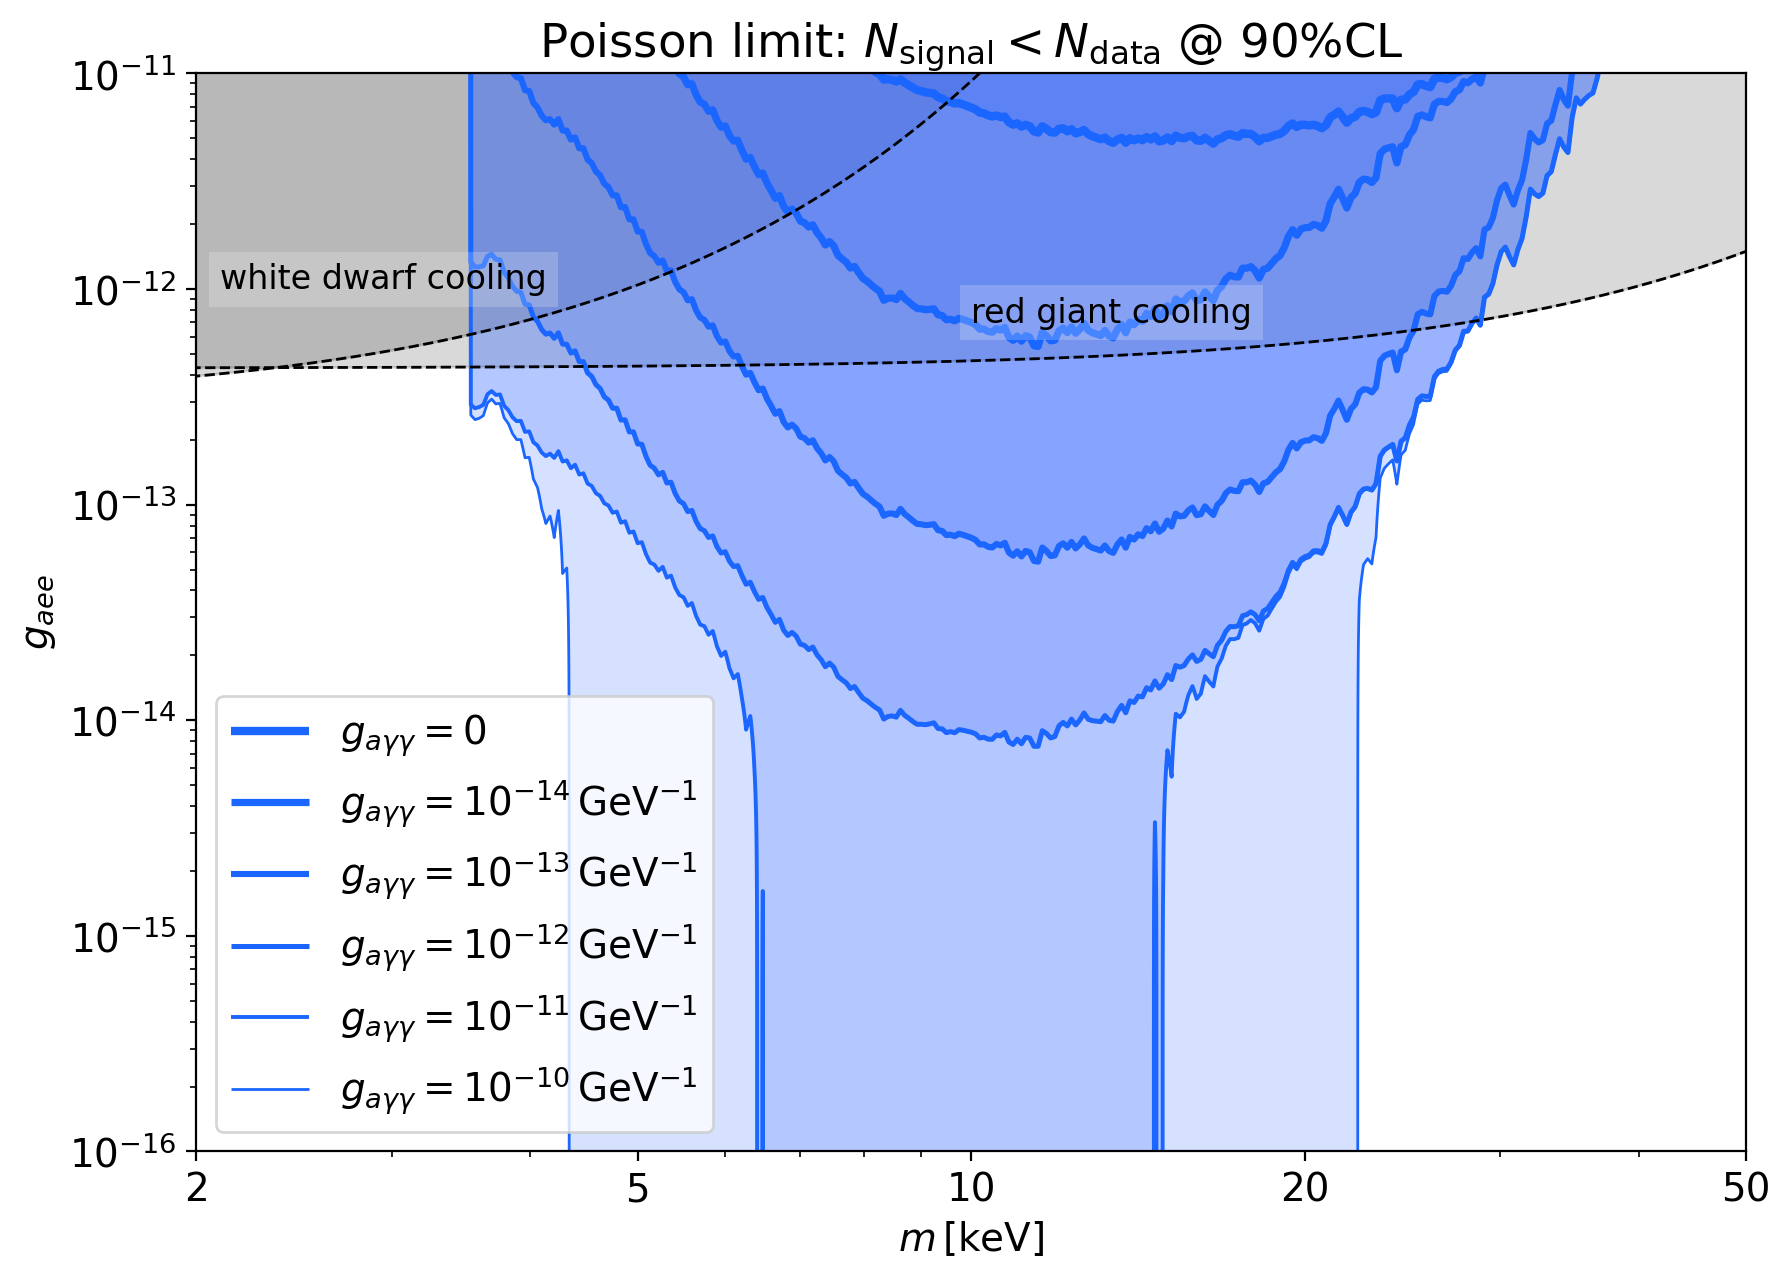

In [112]:
list_lw = np.linspace(3,1,len(list_gagg))
fig_lim_electron2, ax = plt.subplots(1,1,figsize=(10,7))
vec_m = keV * np.logspace(-1,2,np.int(1e3))
ax.plot(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.plot(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],ls='dashed',color='black',lw=1)
ax.fill_between(vec_m/keV,[gaee_lim_WD(m) for m in vec_m],1,color=(0,0,0,0.15))
ax.fill_between(vec_m/keV,[gaee_lim_RG(m) for m in vec_m],1,color=(0,0,0,0.15))
labels = ['$g_{a\gamma\gamma} = 0$','$g_{a\gamma\gamma} = 10^{-14} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-13} \, \mathrm{GeV}^{-1}$',
          '$g_{a\gamma\gamma} = 10^{-12} \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-11}  \, \mathrm{GeV}^{-1}$','$g_{a\gamma\gamma} = 10^{-10} \, \mathrm{GeV}^{-1}$']
for i_g, gagg in enumerate(list_gagg):
    ax.contour(list_m/keV,list_gaee,np.log10(np.transpose(arr_poisson_lim[:,:,i_g])),levels=[0],colors=[(0.1,0.4,1)],linewidths=list_lw[i_g])
    ax.collections[i_g+2].set_label(labels[i_g])
for i_g, gagg in enumerate(list_gagg):
    ax.contourf(list_m/keV,list_gaee,np.log10(np.transpose(arr_poisson_lim[:,:,i_g])),levels=[0,+30],colors=[(0.2,0.4,1,0.2)])
#ax.axvline(gaee_lim_WD(1e-2*keV),ls='dashed',color='black',lw=1)
#for i_m, m in enumerate(list_m):
#    ax.contour(list_gaee,list_gagg,np.log10(np.transpose(arr_poisson_lim[i_m])),levels=[0],
#              colors=[list_colors[i_m]],linewidths = list_lw[i_m]);
#    ax.collections[i_m+1].set_label(labels[i_m])
#ax.contour(list_m/keV,list_gagg,np.log10(np.transpose(arr_poisson_lim)),levels=[0],colors='black',linewidths=[2])
ax.set_xlim(2,50); ax.set_ylim(1e-16,1e-11);
ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel(r'$m \, [\mathrm{keV}]$'); ax.set_ylabel(r'$g_{aee}$'); ax.legend(loc='lower left');
ax.set_title('Poisson limit: $N_\mathrm{signal} < N_\mathrm{data}$ @ 90%CL');
ax.set_xticks([2,5,10,20,50],minor=False)
ax.set_xticklabels([2,5,10,20,50])
ax.text(2.1,1e-12,'white dwarf cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));
ax.text(10,7e-13,'red giant cooling',fontsize=12,bbox=dict(edgecolor=(1,1,1,0),facecolor=(1,1,1,0.2)));

In [113]:
fig_lim_electron2.savefig(FigDir+'lim_electron_poisson.pdf',bbox_inches='tight',pad_inches=0.02);